In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

## Loading data generated in notebooks 1 and 2
Both datasets contain 1000 spectra that have at least 5 matching spectra in the library and 1000 spectra that have no match in the library.

In [3]:
#loading training set
import pickle

outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v = pickle.load(inf)
else:
    print('error')

outfile = os.path.join(path_data, 'old_and_unique_documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_documents_library_s2v = pickle.load(inf)
else:
    print('error')

outfile = os.path.join(path_data, 'old_and_unique_documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_documents_query_s2v = pickle.load(inf)
else:
    print('error')

C:\Users\joris\Documents\eScience_data\data\old_and_unique_found_matches_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\old_and_unique_documents_library_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\old_and_unique_documents_query_s2v.pickle


In [71]:
#loading test set
outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v = pickle.load(inf)
else:
    print('error')

outfile = os.path.join(path_data, 'new_and_unique2_documents_library_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_documents_library_s2v = pickle.load(inf)
else:
    print('error')

outfile = os.path.join(path_data, 'new_and_unique2_documents_query_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_documents_query_s2v = pickle.load(inf)
else:
    print('error')

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_documents_library_s2v.pickle
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_documents_query_s2v.pickle


In [78]:
from rdkit import Chem, DataStructs

def find_info_matches(matches, documents_library, documents_query,
                      add_label = True, add_tanimoto_sim = True, add_cols = False,
                      add_num_matches_transform = True, add_mass_transform = True,
                      add_mass_similarity = True):
    '''
    To each df in matches, add more info like tanimoto scores vs query etc.
    
    A matching inchikey gets label 1 and non-matching 0.

    matches: list of pandas DataFrames, library matching result of query on library
    documents_library: list of SpectrumDocuments, spectra in library
    documents_query: list of SpectrumDocuments, spectra in query set.
        Indices should correspond to indices of matches.
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    add_label: bool, add a label for inchikey match or not
    add_tanimoto_sim: bool, add tanimoto similarity or not
    add_cols: bool/list of str, add other info present in metadata such as parent_mass, adduct
        default: False
    add_num_matches_transform: bool, transform cosine and mod_cosine matches to a number 0-1.
        both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    add_mass_transform: bool, add transform of the parent masses to a fraction of the maximal parent mass
    add_mass_similarity: bool, add similarity of parent mass to the query as a scaled number from 0-1
        where The similarity in dalton is calculated and transformed into a value 0 - 1 by doing
        1 - base_num^diff_in_dalton
    
    Output
    matches_with_info: list of pandas DataFrames, library matching result of query
        on library with matching labels
    '''
    matches_with_info = []
    if add_mass_transform:
        all_q_masses = [documents_query[query_id]._obj.get("parent_mass") \
                            for query_id in range(len(documents_query))]
        all_l_masses = [documents_library[lib_id]._obj.get("parent_mass") \
                            for lib_id in range(len(documents_library))]
        max_parent_mass = max(all_q_masses + all_l_masses)
        print('Max parent mass:', max_parent_mass)

    for query_id in range(len(documents_query)):
        match = matches[query_id].copy()
        if add_label:
            query_inchi = documents_query[query_id]._obj.get("inchikey")[:14]
            match = find_inchikey_match(match, documents_library, query_inchi)
        if add_cols:
            match = find_basic_info(match, documents_library, add_cols)
        if add_tanimoto_sim:
            query_smiles = documents_query[query_id]._obj.get("smiles")
            match = find_tanimoto_sim(match, documents_library, query_smiles)
        if add_num_matches_transform:
            match = transform_num_matches(match)
        if add_mass_transform:
            #add parent_mass if its not there already
            match = find_basic_info(match, documents_library, add_cols = ['parent_mass'])
            match['parent_mass'] = [cur_pm/max_parent_mass for cur_pm in match['parent_mass']]
        if add_mass_similarity:
            if 'mass_match' in match:
                match.drop(['mass_match'], axis=1, inplace=True)
            q_mass = documents_query[query_id]._obj.get("parent_mass")
            match = find_mass_similarity(match, documents_library, q_mass, base_num = 0.8)
        
        matches_with_info.append(match)
    return matches_with_info

def find_inchikey_match(matches, documents_library, query_inchi):
    '''To each match in the matches df, add label for matching inchikey (1) or non-matching (0)

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_inchi: str, first 14 symbols of query inchikey
    df: pandas DataFrame, library matching result of query on library with matching labels
    '''
    matches_with_labels = []
    df = matches.copy()
    library_ids = df.index.values
    labels = []
    for lib_id in library_ids:
        lib_inchi = documents_library[lib_id]._obj.get("inchikey")[:14]
        lab = 0
        if query_inchi == lib_inchi:
            lab = 1
        labels.append(lab)
    df['label'] = labels
    return df

def find_mass_matches(matches, documents_library, query_mass, bins = [2, 5], calc_change = False):
    '''
    To each match in matches df, add the mass change of query to match in bins or a percentage change

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    bins: list of int/float, the cutoff for the mass change, will result in boolean columns,
        i.e. if a cutoff is 2 there will be a column with 1 (true) or 0 (false) for if the mass change
        is within 2
    calc_change: bool, instead of bins add a percentage change of the parent mass difference
    df: pandas DataFrame, library matching result of 1 query on library with mass matches
    '''
    range_bins = range(len(bins)) #calc once
    df = matches.copy()
    library_ids = df.index.values
    masses = [[] for _ in range_bins] #initialise
    mass_changes = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        if calc_change: #calculate a percentage change in parent mass instead of discrete bins
            perc_change = abs(lib_mass - query_mass) / query_mass * 100
            mass_changes.append(perc_change)
        else:
            for bin_i in range_bins:
                cutoff = bins[bin_i]
                lab = 0
                if abs(query_mass - lib_mass) < cutoff:
                    lab = 1
                masses[bin_i].append(lab)
    #add to df
    if calc_change:
        df['perc_mass_change'] = mass_changes
    else:
        for bin_i in range_bins:
            df['mass_match_' + str(bins[bin_i])] = masses[bin_i]
    return df

def find_basic_info(matches, documents_library, add_cols = ['parent_mass']):
    '''
    To each match in matches df, add the info from add_cols entries

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with added info
    '''
    df = matches.copy()
    library_ids = df.index.values
    if add_cols:
        for col in add_cols:
            col_data = []
            for lib_id in library_ids:
                lib_data = documents_library[lib_id]._obj.get(col)
                col_data.append(lib_data)
            df[col] = col_data
    return df

def find_tanimoto_sim(matches, documents_library, query_smiles):
    '''To each match in matches df, add the tanimoto similarity between query and match

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    df: pandas DataFrame, library matching result of 1 query on library with tanimoto similarities
    '''
    df = matches.copy()
    sims = []
    library_ids = df.index.values
    
    if not query_smiles or query_smiles == "None": # check that query smiles exist
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    ms_q = Chem.MolFromSmiles(query_smiles)
    if not ms_q: #in case something is wrong with smiles
        df['similarity'] = [0] * len(library_ids) #default to all 0 if it doesnt exist
        return df
    
    fp_q = Chem.RDKFingerprint(ms_q)
    for lib_id in library_ids:
        smiles_lib = documents_library[lib_id]._obj.get("smiles")
        if smiles_lib and smiles_lib != "None":
            ms_lib = Chem.MolFromSmiles(smiles_lib)
            if ms_lib:
                fp_lib = Chem.RDKFingerprint(ms_lib)
                score = DataStructs.FingerprintSimilarity(fp_q, fp_lib)
            else: #in case something is wrong with smiles
                score = 0
        else: #in case it doesnt have smiles
            score = 0
        sims.append(score)
    df['similarity'] = sims
    return df

def transform_num_matches(input_df, exp = 0.93):
    '''Transform the cosine_matches and mod_cosine_matches to between 0-1
    
    input_df: pandas DataFrame, spec2vec matches for one query
    exp: int, the base for the exponential, default: 0.93
    
    Both matches are transformed to between 0-1 by doing 1-0.93^num_matches
    '''
    df = input_df.copy() #otherwise it edits the df outside the function
    df['cosine_matches'] = [(1-0.93**i) for i in df['cosine_matches']]
    df['mod_cosine_matches'] = [(1-0.93**i) for i in df['mod_cosine_matches']]
    return df

def find_mass_similarity(matches, documents_library, query_mass, base_num = 0.8):
    '''
    To each match in matches df, add a scaled value for how similar the parent_mass is to the query

    matches: pandas DataFrame, library matching result of 1 query on library
    documents_library: list of SpectrumDocuments, spectra in library
    query_mass: float, parent mass of query
    base_num: float, the base for the exponent
    df: pandas DataFrame, library matching result of 1 query on library with mass sims
    
    The similarity in dalton is calculated and transformed into a value 0 - 1 by doing
    1 - base_num^diff_in_dalton
    '''
    df = matches.copy()
    library_ids = df.index.values
    scaled_mass_sims = []
    for lib_id in library_ids:
        lib_mass = documents_library[lib_id]._obj.get("parent_mass")
        mass_diff = abs(lib_mass - query_mass)
        scaled_mass_sim = base_num ** mass_diff
        scaled_mass_sims.append(scaled_mass_sim)

    #add to df
    df['mass_sim'] = scaled_mass_sims
    return df

In [5]:
outfile = os.path.join(path_data, 'nn_prep_old_and_unique_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_old_and_unique_found_matches_s2v = pickle.load(inf)
else:
    nn_prep_old_and_unique_found_matches_s2v = find_info_matches(old_and_unique_found_matches_s2v, old_and_unique_documents_library_s2v, old_and_unique_documents_query_s2v)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_old_and_unique_found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_old_and_unique_found_matches_s2v.pickle


In [6]:
outfile = os.path.join(path_data, 'nn_prep_new_and_unique2_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_new_and_unique2_found_matches_s2v = pickle.load(inf)
else:
    nn_prep_new_and_unique2_found_matches_s2v = find_info_matches(new_and_unique2_found_matches_s2v, new_and_unique2_documents_library_s2v, new_and_unique2_documents_query_s2v)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_new_and_unique2_found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_new_and_unique2_found_matches_s2v.pickle


In [7]:
nn_prep_new_and_unique2_found_matches_s2v[0].sort_values('s2v_score', ascending = False)

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
45439      0.792853        0.195643          0.792853            0.195643   
32666      0.000000        0.000000          0.000000            0.000000   
36488      0.122287        0.070000          0.122721            0.135100   
46660      0.010289        0.070000          0.010289            0.070000   
30026      0.000017        0.070000          0.011877            0.135100   
...             ...             ...               ...                 ...   
80489      0.000000        0.000000          0.000000            0.000000   
15872      0.000000        0.000000          0.000000            0.000000   
51551      0.000000        0.000000          0.000000            0.000000   
14058      0.000000        0.000000          0.012161            0.070000   
68304      0.000000        0.000000          0.000000            0.000000   

       s2v_score  label  similarity  parent_mass  mass_sim  
45439   0.814472      0    0.947368     0.061835  1.000000  
32666   0.606157      0    1.000000     0.061685  0.637861  
36488   0.570656      0    1.000000     0.061535  0.406776  
46660   0.559132      1    1.000000     0.061835  1.000000  
30026   0.550621      0    1.000000     0.061685  0.637861  
...          ...    ...         ...          ...       ...  
80489  -0.034227      0    0.137269     0.061886  0.857873  
15872  -0.034334      0    0.135556     0.061886  0.857873  
51551  -0.042802      0    0.483731     0.061898  0.828708  
14058  -0.067819      0    0.220232     0.061883  0.866724  
68304  -0.079030      0    0.220850     0.061878  0.878994  

[239 rows x 9 columns]

## Training for tanimoto score

In [8]:
#append all the queries and remove the label column
nn_tanimoto_old_and_unique_found_matches_s2v = nn_prep_old_and_unique_found_matches_s2v[0]\
    .append(nn_prep_old_and_unique_found_matches_s2v[1:])\
    .drop(['label'], axis = 1)


In [9]:
nn_tanimoto_new_and_unique2_found_matches_s2v = nn_prep_new_and_unique2_found_matches_s2v[0]\
    .append(nn_prep_new_and_unique2_found_matches_s2v[1:])\
    .drop(['label'], axis = 1)

In [6]:
#top20

def make_s2v_selection(matches, topn):
    '''Return one df with topn matches (based on s2v_score) for each query
    
    matches: list of pandas DataFrames, library matching result with matching labels
    topn: int, number of top hits to select, sorted on s2v_score
    all_selected_matches: pandas DataFrames, concatonated selection of matches for each query
    '''
    selected_matches = []
    for df in matches:
        selected_matches.append(df.sort_values(by=['s2v_score'], ascending=False).iloc[:topn])
    all_selected_matches = selected_matches[0].append(selected_matches[1:])
    return all_selected_matches

In [11]:
nn_tanimoto_top20_old_and_unique_found_matches_s2v = make_s2v_selection(nn_prep_old_and_unique_found_matches_s2v, topn = 20)
nn_tanimoto_top20_old_and_unique_found_matches_s2v.drop(['label'], axis = 1, inplace = True)

nn_tanimoto_top20_new_and_unique2_found_matches_s2v = make_s2v_selection(nn_prep_new_and_unique2_found_matches_s2v, topn = 20)
nn_tanimoto_top20_new_and_unique2_found_matches_s2v.drop(['label'], axis = 1, inplace = True)

In [12]:
plt.hist(nn_tanimoto_top20_old_and_unique_found_matches_s2v['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'training set')
plt.hist(nn_tanimoto_top20_new_and_unique2_found_matches_s2v['similarity'],
         alpha=0.5, bins = np.arange(0,1,0.05), label = 'test set')
plt.legend()
plt.show()

In [7]:
#nn function
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

def train_nn(X_train, y_train, X_test, y_test, layers = [12, 12, 12, 12, 12, 1],
             model_loss = 'binary_crossentropy', activations = 'relu',
             last_activation = 'sigmoid', model_epochs = 20, model_batch_size = 16,
             save_name = False):
    '''Train a keras deep NN and test on test data, returns (model, history, accuracy, loss)
    
    X_train: matrix like object like pd.DataFrame, training set
    y_train: list like object like np.array, training labels
    X_test: matrix like object like pd.DataFrame, test set
    y_test: list like object like np.array, test labels
    layers: list of ints, the number of layers is the len of this list while the elements
        are the amount of neurons per layer, default: [12, 12, 12, 12, 12, 1]
    model_loss: str, loss function, default: binary_crossentropy
    activations: str, the activation of the layers except the last one, default: relu
    last_activation: str, activation of last layer, default: sigmoid
    model_epochs: int, number of epochs, default: 20
    model_batch_size: int, batch size for updating the model, default: 16
    save_name: str, location for saving model, optional, default: False
    
    Returns:
    model: keras sequential
    history: dict, training statistics
    accuracy: float, accuracy on test set
    loss, float, loss on test set
    
    If save_name is not False and save_name exists this function will load existing model
    '''
    if os.path.exists(save_name) and save_name:
        print('\nLoading existing model')
        nn_model = load_model(save_name)
        with open(save_name + '_train_hist.pickle', 'rb') as hist_inf:
            history = pickle.load(hist_inf)
    else:
        # define the keras model
        nn_model = Sequential()
        #add first layer
        nn_model.add(Dense(layers[0], input_dim = X_train.shape[1], activation = activations))
        #add other layers
        for i in range(1,len(layers)-1): #skip first and last one
            nn_model.add(Dense(layers[i], activation = activations))
        #add last layer
        nn_model.add(Dense(layers[-1], activation = last_activation))
        # compile the keras model
        nn_model.compile(loss = model_loss, optimizer='adam', metrics=['accuracy'])
        # fit the keras model on the dataset
        hist = nn_model.fit(X_train, y_train, epochs = model_epochs, batch_size = model_batch_size)
        history = hist.history
    
    #training set
    print('Training loss: {:.4f}\n'.format(history['loss'][-1]))
    
    #test set    
    loss, accuracy = nn_model.evaluate(X_test, y_test)
    print('Test accuracy: {:.2f}'.format(accuracy*100))
    print('Test loss: {:.4f}'.format(loss))
    
    if save_name and not os.path.exists(save_name):
        print('Saving model at:', save_name)
        nn_model.save(save_name)
        with open(save_name + '_train_hist.pickle', 'wb') as hist_outf:
            pickle.dump(history, hist_outf)
    
    return nn_model, history, accuracy, loss

In [14]:
test_layers = [10,24,1]
#model_name = os.path.join(path_data, 'nn_2000_queries_top20_1')
model_name = os.path.join(path_data, 'nn_2000_queries_top20_layers_opt_1') #this one tested best see few cells down
X_tanimoto_top20 = nn_tanimoto_top20_old_and_unique_found_matches_s2v.drop('similarity', axis = 1)
y_tanimoto_top20 = nn_tanimoto_top20_old_and_unique_found_matches_s2v['similarity']
X_tanimoto_top20_test = nn_tanimoto_top20_new_and_unique2_found_matches_s2v.drop('similarity', axis = 1)
y_tanimoto_top20_test = nn_tanimoto_top20_new_and_unique2_found_matches_s2v['similarity']

nn_2000_queries_top20_1 = train_nn(X_tanimoto_top20, y_tanimoto_top20, X_tanimoto_top20_test, y_tanimoto_top20_test, layers = test_layers,
         model_loss = 'mean_squared_error', activations = 'relu', last_activation = None,
         model_epochs = 50, model_batch_size = 16, save_name = model_name)


Loading existing model
Training loss: 0.0493

40000/40000 [==============================] - 4s 98us/sample - loss: 0.0497 - accuracy: 0.1103
Test accuracy: 11.03
Test loss: 0.0497


In [15]:
nn_2000_queries_top20_1_predict = nn_2000_queries_top20_1[0].predict(X_tanimoto_top20_test)

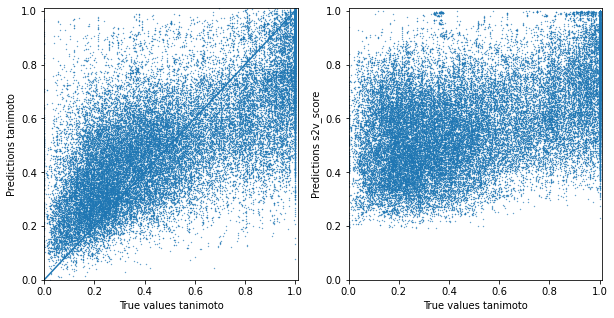

In [78]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True)
# plt.figure(figsize=(5,5))
axs[0].scatter(y_tanimoto_top20_test, nn_2000_queries_top20_1_predict.flatten(), s = 0.1)
lims = [0,1]
axs[0].set_xlim(0,1.01)
axs[0].set_ylim(0,1.01)
axs[0].plot(lims, lims)
axs[0].set_xlabel('True values tanimoto')
axs[0].set_ylabel('Predictions tanimoto')

axs[1].scatter(y_tanimoto_top20_test, X_tanimoto_top20_test.s2v_score, s = 0.1)
axs[1].set_xlabel('True values tanimoto')
axs[1].set_ylabel('Predictions s2v_score')
axs[1].set_ylim(0,1.01)
plt.show()

In [17]:
df = pd.DataFrame({'Actual':y_tanimoto_top20_test,'Predicted':nn_2000_queries_top20_1_predict.flatten()})

tanimoto_thres = 0.6
pred_thres = 0.95
print('Predictions:','\n0->0','1->1')
zero_to_zero = np.sum((df.Actual < tanimoto_thres) & (df.Predicted < pred_thres))
one_to_one = np.sum((df.Actual >= tanimoto_thres) & (df.Predicted >= pred_thres))
print(zero_to_zero, one_to_one)
print('0->1','1->0')
print(np.sum((df.Actual < tanimoto_thres) & (df.Predicted >= pred_thres)), 
np.sum((df.Actual >= tanimoto_thres) & (df.Predicted < pred_thres)))

Predictions: 
0->0 1->1
24656 1562
0->1 1->0
63 13719


In [31]:
#plot precision vs recall with different pred_thresholds
precisions = []
recalls = []
pred_thresholds = np.arange(0, 1, 0.05)
for t in pred_thresholds:
    true_pos = np.sum((df.Actual >= tanimoto_thres) & (df.Predicted >= t))
    true_neg = np.sum((df.Actual < tanimoto_thres) & (df.Predicted < t))
    false_pos = np.sum((df.Actual < tanimoto_thres) & (df.Predicted >= t))
    false_neg = np.sum((df.Actual >= tanimoto_thres) & (df.Predicted < t))
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    precisions.append(precision)
    recalls.append(recall)
# precisions, recalls

In [201]:
#plot precision vs recall with different s2v_thresholds
df_s2v = pd.DataFrame({'Actual':y_tanimoto_top20_test,'Predicted':X_tanimoto_top20_test.s2v_score,
                       'Mass_sim':X_tanimoto_top20_test.mass_sim})
precisions_s2v = []
recalls_s2v = []
m_thres = 0.000705
s2v_thresholds = np.arange(0, 1, 0.05)
for t in s2v_thresholds:
    true_pos = np.sum((df_s2v.Actual >= tanimoto_thres) & (df_s2v.Predicted >= t) & (df_s2v.Mass_sim >= m_thres))
    true_neg = np.sum((df_s2v.Actual < tanimoto_thres) & (df_s2v.Predicted < t))
    false_pos = np.sum((df_s2v.Actual < tanimoto_thres) & (df_s2v.Predicted >= t) & (df_s2v.Mass_sim >= m_thres))
    false_neg = np.sum((df_s2v.Actual >= tanimoto_thres) & (df_s2v.Predicted < t))
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    precisions_s2v.append(precision)
    recalls_s2v.append(recall)
# precisions_s2v, recalls_s2v

In [204]:
from math import log
plt.figure(figsize=(6,5))
plt.scatter(recalls, precisions, label = 'NN tanimoto')
plt.scatter(recalls_s2v, precisions_s2v, label = 's2v_score + mass diff <= {:.1f}Da'.format(log(m_thres, 0.93)))
#add text label for each point
for i, threshold in enumerate(pred_thresholds):
    plt.annotate(">{:.2}".format(threshold),
                (recalls[i], precisions[i]),
                textcoords="offset points", xytext=(2, 5), size = 8)
    plt.annotate(">{:.2}".format(threshold),
                (recalls_s2v[i], precisions_s2v[i]),
                textcoords="offset points", xytext=(-22, -15), size = 8)
plt.legend(loc='lower left')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.35,1)
plt.xlim(0,1.05)
plt.title("Precision vs Recall\nof s2v_score and predicted tanimoto predicting a match >0.6\nusing different cutoffs over whole test set")

Text(0.5, 1.0, 'Precision vs Recall\nof s2v_score and predicted tanimoto predicting a match >0.6\nusing different cutoffs over whole test set')

In [20]:
nn_prep_new_and_unique2_found_matches_s2v[0]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
1720            0.0             0.0          0.013468                0.07   
2702            0.0             0.0          0.000000                0.00   
3345            0.0             0.0          0.000000                0.00   
3602            0.0             0.0          0.000000                0.00   
3992            0.0             0.0          0.000000                0.00   
...             ...             ...               ...                 ...   
80489           0.0             0.0          0.000000                0.00   
80490           0.0             0.0          0.000000                0.00   
88628           0.0             0.0          0.000295                0.07   
88629           0.0             0.0          0.000000                0.00   
88630           0.0             0.0          0.000000                0.00   

       s2v_score  label  similarity  parent_mass  mass_sim  
1720    0.077736      0    0.118721     0.061886  0.859405  
2702    0.096940      0    0.135556     0.061887  0.856152  
3345   -0.016715      0    0.095876     0.061884  0.864985  
3602    0.000847      0    0.135556     0.061887  0.857681  
3992   -0.000847      0    0.302395     0.061887  0.856534  
...          ...    ...         ...          ...       ...  
80489  -0.034227      0    0.137269     0.061886  0.857873  
80490  -0.029796      0    0.137269     0.061886  0.857873  
88628   0.011142      0    0.190067     0.061877  0.883320  
88629  -0.013956      0    0.190067     0.061877  0.883320  
88630  -0.010421      0    0.190067     0.061877  0.883320  

[239 rows x 9 columns]

In [33]:
outfile = os.path.join(path_data, 'nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v = pickle.load(inf)
else:
    nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v = []
    dif_thres = 0.1
    for ID in range(len(nn_prep_new_and_unique2_found_matches_s2v)):
        current_match = nn_prep_new_and_unique2_found_matches_s2v[ID].copy()
        #simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
        predict_on = current_match.drop(['label', 'similarity'], axis = 1)
        predictions = nn_2000_queries_top20_1[0].predict(predict_on)
        current_match['sim_predictions'] = predictions
        correct_guess = [abs(pred - lab) <= dif_thres for pred, lab in zip(predictions, current_match['similarity'])]
        current_match['guess_within_thresh'] = correct_guess
        nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v.append(current_match)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v.pickle


In [154]:
nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[0].sort_values('s2v_score', ascending = False).iloc[:20]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
45439      0.792853        0.195643          0.792853            0.195643   
32666      0.000000        0.000000          0.000000            0.000000   
36488      0.122287        0.070000          0.122721            0.135100   
46660      0.010289        0.070000          0.010289            0.070000   
30026      0.000017        0.070000          0.011877            0.135100   
31738      0.000079        0.070000          0.000103            0.135100   
36127      0.000000        0.000000          0.000000            0.000000   
46256      0.285278        0.135100          0.285278            0.135100   
31390      0.018739        0.135100          0.018739            0.135100   
45802      0.000032        0.070000          0.000032            0.070000   
33096      0.000053        0.070000          0.000053            0.070000   
32187      0.000007        0.070000          0.000007            0.070000   
35636      0.000176        0.070000          0.000176            0.070000   
35417      0.000176        0.070000          0.000176            0.070000   
30591      0.000668        0.195643          0.000668            0.195643   
34567      0.243206        0.070000          0.243206            0.070000   
33637      0.241939        0.070000          0.955195            0.135100   
37625      0.013670        0.070000          0.013693            0.135100   
36290      0.000000        0.000000          0.270046            0.195643   
39095      0.000000        0.000000          0.000000            0.000000   

       s2v_score  label  similarity  parent_mass      mass_sim  \
45439   0.814472      0    0.947368     0.061835  1.000000e+00   
32666   0.606157      0    1.000000     0.061685  6.378614e-01   
36488   0.570656      0    1.000000     0.061535  4.067764e-01   
46660   0.559132      1    1.000000     0.061835  1.000000e+00   
30026   0.550621      0    1.000000     0.061685  6.378614e-01   
31738   0.549179      0    1.000000     0.061535  4.067764e-01   
36127   0.545615      0    1.000000     0.068102  7.086787e-09   
46256   0.538457      0    1.000000     0.063624  4.722366e-03   
31390   0.537693      0    1.000000     0.065713  9.069393e-06   
45802   0.536057      0    1.000000     0.061685  6.378614e-01   
33096   0.533735      0    1.000000     0.061535  4.067764e-01   
32187   0.530141      0    1.000000     0.061535  4.067764e-01   
35636   0.529498      1    1.000000     0.061835  1.000000e+00   
35417   0.529498      1    1.000000     0.061835  1.000000e+00   
30591   0.528718      0    1.000000     0.060641  2.795346e-02   
34567   0.528411      0    0.859649     0.062136  4.066856e-01   
33637   0.528033      0    0.859649     0.062136  4.066856e-01   
37625   0.525377      0    1.000000     0.061685  6.378614e-01   
36290   0.522837      0    0.947368     0.064969  8.418306e-05   
39095   0.520298      0    0.947368     0.061835  1.000000e+00   

       sim_predictions guess_within_thresh  
45439         0.987762              [True]  
32666         0.710993             [False]  
36488         0.537015             [False]  
46660         0.977339              [True]  
30026         0.666530             [False]  
31738         0.622985             [False]  
36127         0.491049             [False]  
46256         0.485759             [False]  
31390         0.477826             [False]  
45802         0.639795             [False]  
33096         0.588366             [False]  
32187         0.585685             [False]  
35636         0.951887              [True]  
35417         0.951887              [True]  
30591         0.604874             [False]  
34567         0.542673             [False]  
33637         0.686877             [False]  
37625         0.614922             [False]  
36290         0.455122             [False]  
39095         0.969708              [True]

## Optimising NN for tanimoto prediction?

In [26]:
testing_layers = [[10,1],
                  [10,24,1],
                  [10,24,10,1],
                  [10,24,48,10,1],
                  [10,24,48,24,10,1],
                  [10,24,24,24,10,1],
                  [10,24,24,24,24,10,1],
                  [10,24,24,24,24,24,10,1],
                  [10,24,24,48,24,24,10,1],
                  [10,48,1],
                  [10,24,48,1],
                  [10,24,48,1],
                  [24,48,1],
                  [48,48,1],
                  [10,96,1]]
base_model_name = os.path.join(path_data, 'nn_2000_queries_top20_layers_opt')
models_testing_layers = []

for i, test_layers in enumerate(testing_layers):
    model_name_x = base_model_name + '_' + str(i)
    nn_2000_queries_top20_x = train_nn(X_tanimoto_top20, y_tanimoto_top20, X_tanimoto_top20_test,
                                       y_tanimoto_top20_test, layers = test_layers,
                                       model_loss = 'mean_squared_error', activations = 'relu', last_activation = None,
                                       model_epochs = 50, model_batch_size = 16, save_name = model_name_x)
    models_testing_layers.append(nn_2000_queries_top20_x)


Loading existing model
Training loss: 0.0532

40000/40000 [==============================] - 1s 37us/sample - loss: 0.0531 - accuracy: 0.1101
Test accuracy: 11.01
Test loss: 0.0531

Loading existing model
Training loss: 0.0493

40000/40000 [==============================] - 2s 41us/sample - loss: 0.0497 - accuracy: 0.1103
Test accuracy: 11.03
Test loss: 0.0497

Loading existing model
Training loss: 0.0490

40000/40000 [==============================] - 2s 46us/sample - loss: 0.0518 - accuracy: 0.1110
Test accuracy: 11.10
Test loss: 0.0518

Loading existing model
Training loss: 0.0472

40000/40000 [==============================] - 2s 50us/sample - loss: 0.0515 - accuracy: 0.1059
Test accuracy: 10.59
Test loss: 0.0515

Loading existing model
Training loss: 0.0486

40000/40000 [==============================] - 2s 48us/sample - loss: 0.0519 - accuracy: 0.1085
Test accuracy: 10.85
Test loss: 0.0519

Loading existing model
Training loss: 0.0476

40000/40000 [==============================

In [27]:
for i, mdl in enumerate(models_testing_layers):
    print('Model {}\tTraining loss {}\tTesting loss {}'.format(i, mdl[1]['loss'][-1], mdl[-1]))

Model 0	Training loss 0.05318167699612677	Testing loss 0.053072650848701594
Model 1	Training loss 0.049322144233062866	Testing loss 0.04971703301668167
Model 2	Training loss 0.049025724140182136	Testing loss 0.051775668741390106
Model 3	Training loss 0.047193532103300094	Testing loss 0.05149269232302904
Model 4	Training loss 0.04857742875479162	Testing loss 0.05188104930669069
Model 5	Training loss 0.04760398161076009	Testing loss 0.0519426240419969
Model 6	Training loss 0.048593950508534905	Testing loss 0.05152778935842216
Model 7	Training loss 0.04915953196920454	Testing loss 0.05264607293326408
Model 8	Training loss 0.04861697160974145	Testing loss 0.050215591561049225
Model 9	Training loss 0.04881005498915911	Testing loss 0.05050803386457264
Model 10	Training loss 0.04921941782943905	Testing loss 0.050357027768716214
Model 11	Training loss 0.04733268672451377	Testing loss 0.05084937635324895
Model 12	Training loss 0.04693132656030357	Testing loss 0.0489735430881381
Model 13	Trainin

## NN classification for predicting similarity bins
Multiple classes: True hit, high sim >0.8, sim >0.6, no hit <0.6

In [166]:
nn_bins_top20_old_and_unique_found_matches_s2v = make_s2v_selection(nn_prep_old_and_unique_found_matches_s2v, topn = 20)
nn_bins_top20_new_and_unique2_found_matches_s2v = make_s2v_selection(nn_prep_new_and_unique2_found_matches_s2v, topn = 20)

In [167]:
#make one hot encoding of class bins
def make_bins_one_hot(similarities, high_sim=0.8, low_sim=0.6):
    '''Return len(4) list with one-hot encoding of 4 label bins
    
    similarities, list of floats, tanimoto similarities compared to the queries
    high_sim: float, high similarity cutoff, default=0.8
    low_sim: float, similarity cutoff, default=0.6
    
    The 4 bins are: True match, high similarity, similarity, no similarity
    '''
    bins_list = []
    for sim in similarities:
        if sim == 1:
            bins = [1, 0, 0, 0]
        elif sim >= high_sim:
            bins = [0, 1, 0, 0]
        elif sim >= low_sim:
            bins = [0, 0, 1, 0]
        else:
            bins = [0, 0, 0, 1]
        bins_list.append(bins)
    return bins_list

y_bins_top20 = make_bins_one_hot(list(nn_bins_top20_old_and_unique_found_matches_s2v['similarity']))
y_bins_top20_test = make_bins_one_hot(list(nn_bins_top20_new_and_unique2_found_matches_s2v['similarity']))

In [63]:
print(y_bins_top20[:10])
nn_bins_top20_old_and_unique_found_matches_s2v.iloc[:10]

[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1]]


cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
45105      0.960780        0.195643          0.960780            0.195643   
37297      0.049197        0.070000          0.971344            0.195643   
47164      0.043040        0.135100          0.043040            0.135100   
45071      0.049498        0.070000          0.961919            0.135100   
31857      0.119678        0.070000          0.608107            0.135100   
32268      0.049271        0.070000          0.949622            0.135100   
32756      0.944742        0.135100          0.944742            0.135100   
45081      0.000000        0.000000          0.938445            0.195643   
55372      0.000000        0.000000          0.961388            0.070000   
29909      0.000000        0.000000          0.961388            0.070000   

       s2v_score  label  similarity  parent_mass      mass_sim  
45105   0.911556      1    1.000000     0.037884  1.000000e+00  
37297   0.887993      0    0.774278     0.038928  4.382372e-02  
47164   0.878756      0    0.907563     0.038478  1.689367e-01  
45071   0.867666      0    0.774278     0.034750  8.418306e-05  
31857   0.844971      0    0.774278     0.038928  4.382372e-02  
32268   0.839834      0    0.774278     0.034750  8.418306e-05  
32756   0.823628      1    1.000000     0.037884  1.000000e+00  
45081   0.779125      0    0.944606     0.036689  2.795346e-02  
55372   0.777170      0    0.170132     0.047592  2.374814e-13  
29909   0.774960      0    0.170132     0.041325  3.351044e-05

[4775, 5800, 4484, 24941]


<BarContainer object of 4 artists>

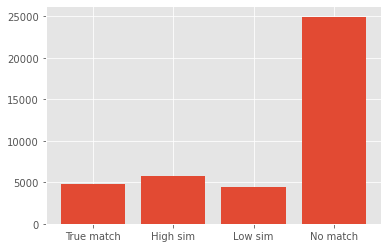

In [100]:
#find label distr
hs = [elem.count(1) for elem in zip(*y_bins_top20)]
print(hs)
xs = ['True match', 'High sim', 'Low sim', 'No match']
plt.bar(xs, hs)

In [168]:
test_layers = [10,24,24,4]
model_name_bins = os.path.join(path_data, 'nn_2000_queries_top20_bins_1')
X_bins_top20 = nn_bins_top20_old_and_unique_found_matches_s2v.drop(['label', 'similarity'], axis = 1)
X_bins_top20_test = nn_bins_top20_new_and_unique2_found_matches_s2v.drop(['label', 'similarity'], axis = 1)

nn_2000_queries_top20_bins = train_nn(X_bins_top20, np.array(y_bins_top20), X_bins_top20_test,
                                   np.array(y_bins_top20_test), layers = test_layers,
                                   model_loss = 'categorical_crossentropy', activations = 'relu',
                                   last_activation = 'sigmoid', model_epochs = 50,
                                   model_batch_size = 16, save_name = model_name_bins)


Loading existing model
Training loss: 0.7471

40000/40000 [==============================] - 2s 61us/sample - loss: 0.8435 - accuracy: 0.6981
Test accuracy: 69.81
Test loss: 0.8435


In [109]:
nn_tested_bins_top20_new_and_unique2_found_matches_s2v = []
for ID in range(len(nn_prep_new_and_unique2_found_matches_s2v)):
    current_match = nn_prep_new_and_unique2_found_matches_s2v[ID].copy()
    #simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions_classes = nn_2000_queries_top20_bins[0].predict_classes(predict_on)
    predictions = nn_2000_queries_top20_bins[0].predict(predict_on)
    current_match['class_predictions'] = predictions_classes
    current_match['predictions'] = [tuple(round(elem,2) for elem in pred) for pred in predictions]
#     correct_guess = [abs(pred - lab) <= dif_thres for pred, lab in zip(predictions, current_match['similarity'])]
#     current_match['guess_within_thresh'] = correct_guess
    nn_tested_bins_top20_new_and_unique2_found_matches_s2v.append(current_match)

In [108]:
[tuple(round(elem,2) for elem in pred) for pred in predictions]

[(0.01, 0.0, 0.0, 0.08),
 (0.0, 0.0, 0.0, 0.05),
 (0.0, 0.0, 0.01, 0.09),
 (0.0, 0.0, 0.01, 0.37),
 (0.0, 0.0, 0.01, 0.07),
 (0.0, 0.0, 0.0, 0.04),
 (0.0, 0.0, 0.01, 0.22),
 (0.0, 0.0, 0.0, 0.07),
 (0.0, 0.01, 0.07, 0.46),
 (0.0, 0.0, 0.0, 0.06),
 (0.0, 0.0, 0.01, 0.34),
 (0.0, 0.0, 0.0, 0.03),
 (0.0, 0.0, 0.0, 0.18),
 (0.0, 0.0, 0.0, 0.18),
 (0.0, 0.0, 0.01, 0.01),
 (0.0, 0.0, 0.0, 0.04),
 (0.01, 0.0, 0.0, 0.05),
 (0.0, 0.0, 0.0, 0.04),
 (0.0, 0.0, 0.01, 0.35),
 (0.01, 0.0, 0.01, 0.17),
 (0.01, 0.02, 0.15, 0.87),
 (0.0, 0.0, 0.0, 0.26),
 (0.03, 0.05, 0.16, 0.81),
 (0.01, 0.0, 0.0, 0.08),
 (0.0, 0.0, 0.01, 0.46),
 (0.0, 0.0, 0.0, 0.23),
 (0.0, 0.05, 0.22, 0.28),
 (0.0, 0.03, 0.14, 0.26),
 (0.0, 0.02, 0.14, 0.49),
 (0.01, 0.0, 0.01, 0.16),
 (0.01, 0.0, 0.0, 0.06),
 (0.0, 0.0, 0.0, 0.09),
 (0.0, 0.0, 0.0, 0.32),
 (0.01, 0.0, 0.0, 0.14),
 (0.06, 0.02, 0.03, 0.06),
 (0.0, 0.04, 0.18, 0.32),
 (0.0, 0.0, 0.0, 0.25),
 (0.01, 0.0, 0.01, 0.13),
 (0.02, 0.03, 0.18, 0.87),
 (0.05, 0.05, 0.24, 0.7

In [87]:
nn_2000_queries_top20_bins[0].predict_classes(predict_on.sort_values(by=['s2v_score'], ascending=False))

array([2, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3], dtype=int64)

In [111]:
nn_tested_bins_top20_new_and_unique2_found_matches_s2v[1].sort_values(by=['s2v_score'], ascending = False).iloc[:10]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
66196      0.997898        0.637956          0.997898            0.637956   
65988      0.442213        0.581404          0.442213            0.581404   
67788      0.973057        0.581404          0.973057            0.581404   
66043      0.973057        0.581404          0.973057            0.581404   
7167       0.545044        0.304312          0.545044            0.304312   
17281      0.888163        0.195643          0.888163            0.195643   
66339      0.777920        0.479589          0.777920            0.479589   
88004      0.245620        0.195643          0.245620            0.195643   
87824      0.225801        0.304312          0.225801            0.304312   
87573      0.240569        0.195643          0.240569            0.195643   

       s2v_score  label  similarity  parent_mass      mass_sim  \
66196   0.839695      1    1.000000     0.041980  1.000000e+00   
65988   0.620984      1    1.000000     0.041980  1.000000e+00   
67788   0.598642      1    1.000000     0.041980  1.000000e+00   
66043   0.598642      1    1.000000     0.041980  1.000000e+00   
7167    0.495941      0    0.411520     0.028856  8.600711e-18   
17281   0.416025      0    0.423473     0.044594  3.987625e-04   
66339   0.382843      1    1.000000     0.041980  1.000000e+00   
88004   0.358107      0    0.090494     0.012750  9.790996e-39   
87824   0.354349      0    0.067490     0.012745  9.622057e-39   
87573   0.340198      0    0.202258     0.012606  6.346448e-39   

       class_predictions               predictions  
66196                  0   (0.05, 0.03, 0.03, 0.0)  
65988                  0  (0.15, 0.06, 0.02, 0.01)  
67788                  2  (0.04, 0.04, 0.06, 0.01)  
66043                  2  (0.04, 0.04, 0.06, 0.01)  
7167                   3  (0.01, 0.02, 0.08, 0.84)  
17281                  3  (0.01, 0.04, 0.09, 0.86)  
66339                  0  (0.07, 0.05, 0.04, 0.03)  
88004                  3    (0.0, 0.0, 0.01, 0.91)  
87824                  3    (0.0, 0.0, 0.02, 0.92)  
87573                  3    (0.0, 0.0, 0.01, 0.92)

### Oversample to get equal label distribution

In [169]:
#oversample labels to get equal ratio, while labels are in one hot encoding
def oversample_one_hot(matches, labels):
    '''Oversamples the underrepresented labels so that all labels are equal

    matches: pandas DataFrame, concatenation of all queries matching to a library
    labels: list of lists of int, one-hot encoding of labels
    
    Labels are a list of 0s and 1s. Underrepresented labels are multiplied to
    get to the same number as the label with highest prevalence
    '''
#     matches = matches_ori.copy()
    label_counts = [elem.count(1) for elem in zip(*labels)]
    max_count = max(label_counts)
    max_i = np.argmax(label_counts)
    #get the reference values
    ref_ind = [j for j, elem in enumerate(labels) if elem[max_i]==1]
    ref = matches.copy().iloc[ref_ind]
    len_ref = ref.shape[0]
    
    #add label as list of tuples to ref so sample will work later
    ref_label = labels[ref_ind[0]]
    ref['lab'] = [tuple(ref_label)] * len_ref
    #initialise matches_oversampled with ref
    matches_oversampled = ref.copy()
    #oversample each non ref label
    for i, count in enumerate(label_counts):
        if not i == max_i: #skip ref
            current_ind = [j for j, elem in enumerate(labels) if elem[i]==1]
            current = matches.copy().iloc[current_ind]
            len_current = current.shape[0]
            current_label = labels[current_ind[0]]
            current['lab'] = [tuple(current_label)] * len_current
            #find how many times oversampling is needed
            ratio = len_ref / len_current
            #choose a fraction of the data to correct for the decimals
            decimals = ratio % 1
            np.random.seed(42)
            chosen_indices = np.random.choice(range(len_current), round(decimals*len_current))
            balanced_current = current.iloc[chosen_indices]
            #add current data int(ratio) many times
            for k in range(1, int(ratio)+1):
                balanced_current = balanced_current.append(current)
            #add to complete oversampled dataset
            matches_oversampled = matches_oversampled.append(balanced_current)
    #shuffle data to mix labels
    np.random.seed(42)
    matches_oversampled = matches_oversampled.sample(frac=1)
    labels_oversampled = [list(elem) for elem in matches_oversampled['lab']] #remove label column
    matches_oversampled.drop('lab', axis = 1, inplace = True)
    print('New shape:', matches_oversampled.shape)
    return matches_oversampled, labels_oversampled

In [170]:
X_bins_top20_oversampled, y_bins_top20_oversampled = oversample_one_hot(X_bins_top20, y_bins_top20)

New shape: (99764, 7)


In [160]:
[elem.count(1) for elem in zip(*y_bins_top20_oversampled)]

[24941, 24941, 24941, 24941]

In [161]:
y_bins_top20_oversampled

[[0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 0, 1,

In [171]:
test_layers = [10,24,24,4]
model_name_bins_oversampled = os.path.join(path_data, 'nn_2000_queries_top20_bins_oversampled')
X_bins_top20_oversampled_test, y_bins_top20_oversampled_test = oversample_one_hot(X_bins_top20_test, y_bins_top20_test)

nn_2000_queries_top20_bins_overs = train_nn(X_bins_top20_oversampled, np.array(y_bins_top20_oversampled), X_bins_top20_oversampled_test,
                                   np.array(y_bins_top20_oversampled_test), layers = test_layers,
                                   model_loss = 'categorical_crossentropy', activations = 'relu',
                                   last_activation = 'sigmoid', model_epochs = 50,
                                   model_batch_size = 16, save_name = model_name_bins_oversampled)

New shape: (98876, 7)

Loading existing model
Training loss: 0.9764

98876/98876 [==============================] - 4s 43us/sample - loss: 1.0281 - accuracy: 0.5599
Test accuracy: 55.99
Test loss: 1.0281


In [172]:
nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v = []
for ID in range(len(nn_prep_new_and_unique2_found_matches_s2v)):
    current_match = nn_prep_new_and_unique2_found_matches_s2v[ID].copy()
    #simlabs = [1 if sim >= sim_cutoff else 0 for sim in current_match['similarity']]
    predict_on = current_match.drop(['label', 'similarity'], axis = 1)
    predictions_classes = nn_2000_queries_top20_bins[0].predict_classes(predict_on)
    predictions = nn_2000_queries_top20_bins_overs[0].predict(predict_on)
    current_match['class_predictions'] = predictions_classes
    #add highest predicted probablity (so the class pred probability) as confidence score
    current_match['prediction_prob'] = [round(max(pred),2) for pred in predictions]
    current_match['predictions'] = [tuple(round(elem,2) for elem in pred) for pred in predictions]
    
#     correct_guess = [abs(pred - lab) <= dif_thres for pred, lab in zip(predictions, current_match['similarity'])]
#     current_match['guess_within_thresh'] = correct_guess
    nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v.append(current_match)

In [209]:
nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v[1].sort_values('s2v_score', ascending = False).iloc[:10]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
66196      0.997898        0.637956          0.997898            0.637956   
65988      0.442213        0.581404          0.442213            0.581404   
67788      0.973057        0.581404          0.973057            0.581404   
66043      0.973057        0.581404          0.973057            0.581404   
7167       0.545044        0.304312          0.545044            0.304312   
17281      0.888163        0.195643          0.888163            0.195643   
66339      0.777920        0.479589          0.777920            0.479589   
88004      0.245620        0.195643          0.245620            0.195643   
87824      0.225801        0.304312          0.225801            0.304312   
87573      0.240569        0.195643          0.240569            0.195643   

       s2v_score  label  similarity  parent_mass      mass_sim  \
66196   0.839695      1    1.000000     0.041980  1.000000e+00   
65988   0.620984      1    1.000000     0.041980  1.000000e+00   
67788   0.598642      1    1.000000     0.041980  1.000000e+00   
66043   0.598642      1    1.000000     0.041980  1.000000e+00   
7167    0.495941      0    0.411520     0.028856  8.600711e-18   
17281   0.416025      0    0.423473     0.044594  3.987625e-04   
66339   0.382843      1    1.000000     0.041980  1.000000e+00   
88004   0.358107      0    0.090494     0.012750  9.790996e-39   
87824   0.354349      0    0.067490     0.012745  9.622057e-39   
87573   0.340198      0    0.202258     0.012606  6.346448e-39   

       class_predictions  prediction_prob               predictions  
66196                  0             0.50   (0.5, 0.39, 0.06, 0.01)  
65988                  0             0.52  (0.52, 0.15, 0.09, 0.01)  
67788                  2             0.25  (0.12, 0.08, 0.25, 0.01)  
66043                  2             0.25  (0.12, 0.08, 0.25, 0.01)  
7167                   3             0.46    (0.03, 0.2, 0.2, 0.46)  
17281                  3             0.43  (0.02, 0.18, 0.18, 0.43)  
66339                  2             0.37   (0.06, 0.0, 0.37, 0.02)  
88004                  3             0.62    (0.0, 0.05, 0.1, 0.62)  
87824                  3             0.68  (0.01, 0.06, 0.11, 0.68)  
87573                  3             0.64   (0.01, 0.05, 0.1, 0.64)

## Making the well known performance plot

In [205]:
#testing if top hit is above 0.6 similarity
#look at top20
test_tan_nn_top20 = []
test_sim_mcos = []
test_sim_s2v = []
ideal_case_top20 = []
test_bins_nn_top20_overs = []

pred_thresh = 0.6
mass_sim_thresh = 0.000705
restr_nn = False # do mass+spec2vec restricitons on nn models
highest_pred = False # take highest prediction instead of first prediction over threshold
highest_class = True # take highest predicted class instead of first prediction over threshold
threshold = 0.4
topn = 20 #only look at top 20
sim_threshold = 0.6
mc_matches_thresh = 0.35 # mod cosine matches threshold corresponds to min match 6
bins_exclude = [3] #classes to filter out with bins nn
restr_pred = 0.35 #cutoff for the class prediction probability

for ID in range(len(nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v)):
    # mass + mod cosine
    current_match = nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['mod_cosine_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['mod_cosine_score'] > threshold)
                                  & (current_match['mod_cosine_matches'] > mc_matches_thresh)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['mod_cosine_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_mcos.append(best_bet)

    # Scenario 1: mass + Spec2Vec + threshold
    current_match = nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    #inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    #current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_s2v.append(best_bet)
    
    # Scenario 3: (Spec2Vec + threshold) after filtering for non-similar matches with nn
    if not restr_nn:
        df_select = current_match[(current_match['sim_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['sim_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['sim_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_tan_nn_top20.append(best_bet)
    
    # ideal case: how many queries have an actual match above s2v threshold and >0.6 tanimoto
    df_select = current_match[(current_match['s2v_score'] > threshold)]
    best_bet = -1
    if df_select.shape[0] > 0:
        if any(df_select['similarity'] > 0.6):
            best_bet = 1
    ideal_case_top20.append(best_bet)
    
    # Scenario 4: (Spec2Vec + threshold) after filtering for non-similar matches with nn for oversampled bins
    current_match = nn_tested_bins_top20_oversampled_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    df_select = current_match.query('class_predictions not in @bins_exclude')
    if restr_nn:
        df_select = df_select[(df_select['mass_sim'] >= mass_sim_thresh)
                                      & (df_select['s2v_score'] > threshold)]
    if restr_pred:
        df_select = df_select[(df_select['prediction_prob'] >= restr_pred)]
    
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_class:
            #look at highest predicted: identical match is class 0
            sim = df_select.iloc[np.argmin(df_select['class_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_bins_nn_top20_overs.append(best_bet)
    
test_tan_nn_top20_arr = np.array(test_tan_nn_top20)
test_sim_mcos_arr = np.array(test_sim_mcos)
test_sim_s2v_arr = np.array(test_sim_s2v)
ideal_case_top20_arr = np.array(ideal_case_top20)
test_bins_nn_top20_overs_arr = np.array(test_bins_nn_top20_overs)

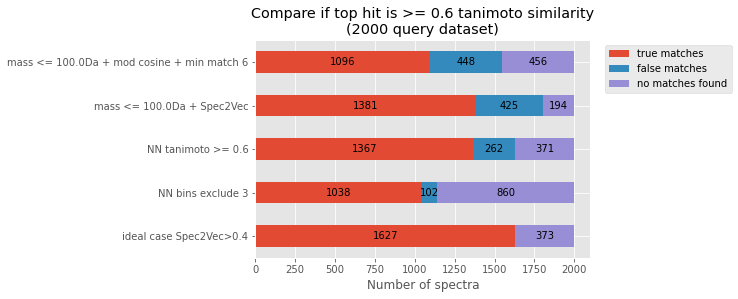

In [206]:
from math import log
plt.style.use('ggplot')
da_diff = log(mass_sim_thresh, 0.93)

if restr_nn:
    ylabels = ['mass <= {:.1f}Da + mod cosine + min match 6'.format(da_diff),
               'mass <= {:.1f}Da + Spec2Vec'.format(da_diff),
               'mass <= {:.1f}Da + Spec2Vec + NN tanimoto >= {}'.format(da_diff, pred_thresh),
               'ideal case Spec2Vec>0.4',
               'mass + Spec2Vec + NN bins exclude {}'.format(', '.join(map(str,bins_exclude)))]
else:
    ylabels = ['mass <= {:.1f}Da + mod cosine + min match 6'.format(da_diff),
               'mass <= {:.1f}Da + Spec2Vec'.format(da_diff),
               'NN tanimoto >= {}'.format(pred_thresh),
               'ideal case Spec2Vec>0.4',
               'NN bins exclude {}'.format(', '.join(map(str,bins_exclude)))]
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_sim_mcos_arr == 1), np.sum(test_sim_mcos_arr == 0), np.sum(test_sim_mcos_arr == -1)],
                 [np.sum(test_sim_s2v_arr == 1), np.sum(test_sim_s2v_arr == 0), np.sum(test_sim_s2v_arr == -1)],
                 [np.sum(test_tan_nn_top20_arr == 1), np.sum(test_tan_nn_top20_arr == 0), np.sum(test_tan_nn_top20_arr == -1)],
                 [np.sum(ideal_case_top20_arr == 1), np.sum(ideal_case_top20_arr == 0), np.sum(ideal_case_top20_arr == -1)],
                 [np.sum(test_bins_nn_top20_overs_arr == 1), np.sum(test_bins_nn_top20_overs_arr == 0), np.sum(test_bins_nn_top20_overs_arr == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

#fig, ax = plt.subplots(figsize=(5, 5))
ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none', figsize=(6, 4))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if width != 0:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(width), 
                horizontalalignment='center', 
                verticalalignment='center')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Compare if top hit is >= {} tanimoto similarity\n(2000 query dataset)'.format(sim_threshold))
#plt.figure(figsize=(5,5))
plt.show()

## PCA

In [235]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principal_components = pca.fit_transform(X_bins_top20)
principal_df = pd.DataFrame(data = principal_components,
                           columns = ['PC1', 'PC2', 'PC3', 'PC4'])
pca.explained_variance_ratio_

array([0.48671871, 0.27323627, 0.18129547, 0.03188169])

In [237]:
cat_labs = ['Similar' if score >= 0.6 else 'Non-similar' for score in y_tanimoto_top20]
label_df = pd.DataFrame(cat_labs, columns = ['target'])
final_df = pd.concat([principal_df, label_df], axis = 1)
final_df

PC1       PC2       PC3       PC4       target
0      0.331354  1.145551  0.518929 -0.030552      Similar
1     -0.444350  0.569380 -0.135958  0.559953      Similar
2     -0.729095  0.109895  0.253081 -0.091388      Similar
3     -0.496756  0.582539 -0.165980  0.539680      Similar
4     -0.583225  0.441300 -0.037412  0.249301      Similar
...         ...       ...       ...       ...          ...
39995 -0.037546 -0.696762 -0.079942 -0.062997  Non-similar
39996  0.417285  0.001047 -0.411345 -0.051617      Similar
39997 -0.050804 -0.494532 -0.118788 -0.062408  Non-similar
39998  0.015806 -0.623574 -0.119762 -0.033965  Non-similar
39999 -0.085054 -0.696925 -0.063575 -0.040335  Non-similar

[40000 rows x 5 columns]

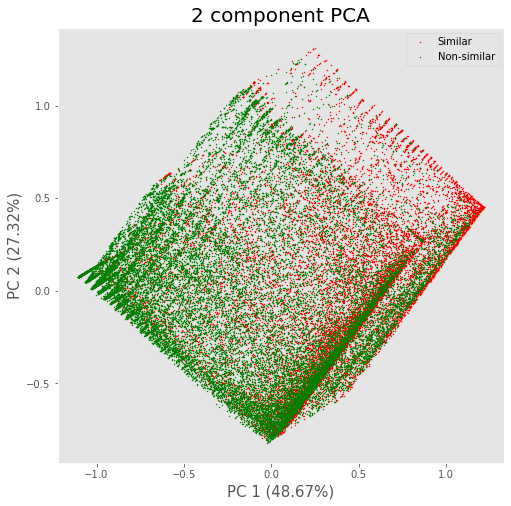

In [241]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0]*100), fontsize = 15)
ax.set_ylabel('PC 2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1]*100), fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Similar', 'Non-similar']
colours = ['r', 'g']
for target, colour in zip(targets,colours):
    indices_to_keep = final_df['target'] == target
    ax.scatter(final_df.loc[indices_to_keep, 'PC1'],
               final_df.loc[indices_to_keep, 'PC2'],
               c = colour, s = 0.9)
ax.legend(targets)
ax.grid()

## Include more s2v scores in deep learning ensemble model

### Load models

In [2]:
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")
from library_search import library_matching
import pickle

In [4]:
from matchms.importing import load_from_json
outfile = os.path.join(path_data, 'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        spectrums = pickle.load(inf)
else:
    filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
    spectrums = load_from_json(filename)
    with open(outfile, 'wb') as outf:
        pickle.dump(spectrums, outf)

print("number of spectra:", len(spectrums))

C:\Users\joris\Documents\eScience_data\data\gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle
number of spectra: 112956


In [5]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

95320 remaining spectra.


In [ ]:
del(spectrums)

In [11]:
old_unique_spec_ids = set([spec._obj.get("spectrumid") for spec in old_and_unique_documents_query_s2v])
new_unique2_spec_ids = set([spec._obj.get("spectrumid") for spec in new_and_unique2_documents_query_s2v])

In [ ]:
from spec2vec import SpectrumDocument

old_and_unique_documents_library_s2v_1dec = []
old_and_unique_documents_query_s2v_1dec = []
old_and_unique_documents_library_s2v_2dec = []
old_and_unique_documents_query_s2v_2dec = []
old_and_unique_documents_library_s2v_3dec = []
old_and_unique_documents_query_s2v_3dec = []

new_and_unique2_documents_library_s2v_1dec = []
new_and_unique2_documents_query_s2v_1dec = []
new_and_unique2_documents_library_s2v_2dec = []
new_and_unique2_documents_query_s2v_2dec = []
new_and_unique2_documents_library_s2v_3dec = []
new_and_unique2_documents_query_s2v_3dec = []

for spec in spectrums_s2v:
    spec_id = spec.get("spectrumid")

    if spec_id in old_unique_spec_ids:
        old_and_unique_documents_query_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
        old_and_unique_documents_query_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        old_and_unique_documents_query_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))
    else:
        old_and_unique_documents_library_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
        old_and_unique_documents_library_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        old_and_unique_documents_library_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))
    
    if spec_id in new_unique2_spec_ids:
        new_and_unique2_documents_query_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
        new_and_unique2_documents_query_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        new_and_unique2_documents_query_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))
    else:
        new_and_unique2_documents_library_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
        new_and_unique2_documents_library_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        new_and_unique2_documents_library_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))

In [13]:
#load models
path_models = os.path.join(path_data, "trained_models")
model_file1 = os.path.join(path_models, "spec2vec_library_testing_4000removed_1dec.model")
model1 = gensim.models.Word2Vec.load(model_file1)
print(model1)

import pickle
outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v_1dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v_1dec = pickle.load(inf)
else:
    old_and_unique_found_matches_s2v_1dec = library_matching(old_and_unique_documents_query_s2v_1dec,
                                                             old_and_unique_documents_library_s2v_1dec,
                                                             model1,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_found_matches_s2v_1dec, outf)

outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v_1dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v_1dec = pickle.load(inf)
else:
    new_and_unique2_found_matches_s2v_1dec = library_matching(new_and_unique2_documents_query_s2v_1dec,
                                                             new_and_unique2_documents_library_s2v_1dec,
                                                             model1,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_found_matches_s2v_1dec, outf)

Word2Vec(vocab=11787, size=300, alpha=0.025)
C:\Users\joris\Documents\eScience_data\data\old_and_unique_found_matches_s2v_1dec.pickle
Pre-selection includes spec2vec top 200.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.96%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.48%.
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v_1dec.pickle
Pre-selection includes spec2vec top 200.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.48%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.96%.


In [7]:
#load models
path_models = os.path.join(path_data, "trained_models")
model_file2 = os.path.join(path_models, "spec2vec_library_testing_4000removed_2dec.model")
model2 = gensim.models.Word2Vec.load(model_file2)
print(model2)

import pickle
outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v_2dec = pickle.load(inf)
else:
    old_and_unique_found_matches_s2v_2dec = library_matching(old_and_unique_documents_query_s2v_2dec,
                                                             old_and_unique_documents_library_s2v_2dec,
                                                             model2,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_found_matches_s2v_2dec, outf)

outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v_2dec = pickle.load(inf)
else:
    new_and_unique2_found_matches_s2v_2dec = library_matching(new_and_unique2_documents_query_s2v_2dec,
                                                             new_and_unique2_documents_library_s2v_2dec,
                                                             model2,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_found_matches_s2v_2dec, outf)

Word2Vec(vocab=115877, size=300, alpha=0.025)
C:\Users\joris\Documents\eScience_data\data\old_and_unique_found_matches_s2v_2dec.pickle
C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v_2dec.pickle


In [15]:
#load models
path_models = os.path.join(path_data, "trained_models")
model_file3 = os.path.join(path_models, "spec2vec_library_testing_4000removed_3dec.model")
model3 = gensim.models.Word2Vec.load(model_file3)
print(model3)

import pickle
outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v_3dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v_3dec = pickle.load(inf)
else:
    old_and_unique_found_matches_s2v_3dec = library_matching(old_and_unique_documents_query_s2v_3dec,
                                                             old_and_unique_documents_library_s2v_3dec,
                                                             model3,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_found_matches_s2v_3dec, outf)

Word2Vec(vocab=987631, size=300, alpha=0.025)
C:\Users\joris\Documents\eScience_data\data\old_and_unique_found_matches_s2v_3dec.pickle
Pre-selection includes spec2vec top 200.
Found 21 word(s) missing in the model. Weighted fraction not covered is 8.29%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.52%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.75%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 15.64%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 3.49%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Found 63 word(s) missing in the model. Weighted fraction not covered is 11.47%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.83%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 36.55%.
Found 5 word(s) missing in the model. 

Found 1 word(s) missing in the model. Weighted fraction not covered is 1.97%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 3.46%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.26%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.11%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.26%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.26%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.27%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.64%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 3.71%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.02%.
Found 1 word(s) missing in the model. Weighted fraction not cove

Found 6 word(s) missing in the model. Weighted fraction not covered is 1.05%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.06%.
Found 14 word(s) missing in the model. Weighted fraction not covered is 3.09%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 1.33%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 3.58%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.11%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.54%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.85%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.74%.
Found 39 word(s) missing in the model. Weighted fraction not covered is 6.36%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.74%.
Found 2 word(s) missing in the model. Weighted fraction not co

Found 3 word(s) missing in the model. Weighted fraction not covered is 0.53%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.73%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.62%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.27%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.27%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.18%.
Found 8 word(s) missing in the model. Weighted fraction not cove

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.57%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 9.12%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.05%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.77%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.04%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 5.37%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.99%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.17%.
Found 21 word(s) missing in the model. Weighted fraction not cov

Found 4 word(s) missing in the model. Weighted fraction not covered is 4.49%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.66%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.61%.
Found 14 word(s) missing in the model. Weighted fraction not covered is 4.90%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 2.04%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.05%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.17%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.69%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.86%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.08%.
Found 14 word(s) missing in the model. Weighted fraction not co

Found 3 word(s) missing in the model. Weighted fraction not covered is 3.63%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.16%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.91%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 3.93%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 3.47%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.62%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.96%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.57%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.77%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.67%.
Found 1 word(s) missing in the model. Weighted fraction not cove

Found 3 word(s) missing in the model. Weighted fraction not covered is 4.21%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 2.31%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.01%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.69%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 8.71%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 5.52%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.90%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.72%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.57%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 4.86%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 2.62%.
Found 7 word(s) missing in the model. Weighted fraction not cov

Found 4 word(s) missing in the model. Weighted fraction not covered is 3.31%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.83%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.36%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.53%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.97%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.92%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.10%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 4.07%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Found 1 word(s) missing in the model. Weighted fraction not cove

Found 28 word(s) missing in the model. Weighted fraction not covered is 10.70%.
Found 52 word(s) missing in the model. Weighted fraction not covered is 14.96%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.77%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.66%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 133 word(s) missing in the model. Weighted fraction not covered is 20.49%.
Found 117 word(s) missing in the model. Weighted fraction not covered is 17.79%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.59%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.64%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.99%.
Found 112 word(s) missing in the model. Weighted fract

Found 33 word(s) missing in the model. Weighted fraction not covered is 6.36%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.45%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.85%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.37%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.43%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 9.91%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 2.47%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.31%.
Found 13 word(s) missing in the model. Weighted fraction not c

Found 2 word(s) missing in the model. Weighted fraction not covered is 1.38%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.78%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.50%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.61%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.79%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 3.02%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.80%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 4 word(s) missing in the model. Weighted fraction not cov

Found 8 word(s) missing in the model. Weighted fraction not covered is 2.39%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.34%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.34%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.47%.
Found 13 word(s) missing in the model. Weighted fraction not covered is 4.16%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.52%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 6.54%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.60%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Found 2 word(s) missing in the model. Weighted fraction not co

Found 13 word(s) missing in the model. Weighted fraction not covered is 2.37%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.22%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 1.92%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 19 word(s) missing in the model. Weighted fraction not covered is 5.36%.
Found 19 word(s) missing in the model. Weighted fraction not covered is 7.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.22%.
Found 34 word(s) missing in the model. Weighted fraction not covered is 13.30%.
Found 16 word(s) missing in the model. Weighted fraction n

Found 9 word(s) missing in the model. Weighted fraction not covered is 3.22%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.82%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.82%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.53%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 4.11%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.44%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.08%.
Found 2 word(s) missing in the model. Weighted fraction not cov

Found 11 word(s) missing in the model. Weighted fraction not covered is 2.00%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 3.99%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 7.08%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 4.07%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.48%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.06%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 3.37%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.50%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 3.62%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 10.99%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 6.96%.
Found 7 word(s) missing in the model. Weighted fraction not 

Found 7 word(s) missing in the model. Weighted fraction not covered is 1.96%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.49%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.37%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 3.90%.
Found 13 word(s) missing in the model. Weighted fraction not covered is 3.88%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.76%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.40%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.54%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.66%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.48%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.31%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.08%.
Found 1 word(s) missing in the model. Weighted fraction not c

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.64%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.62%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 3.35%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.65%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.61%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 9 word(s) missing in the model. Weighted fraction not cove

In [16]:
#largest fraction missing is 36.55%.
outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v_3dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v_3dec = pickle.load(inf)
else:
    new_and_unique2_found_matches_s2v_3dec = library_matching(new_and_unique2_documents_query_s2v_3dec,
                                                             new_and_unique2_documents_library_s2v_3dec,
                                                             model3,
                                                             presearch_based_on=["spec2vec-top200"],
                                                             ignore_non_annotated=True,
                                                             intensity_weighting_power=0.5,
                                                             allowed_missing_percentage=100,
                                                             cosine_tol=0.005,
                                                             mass_tolerance=1.0)
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_found_matches_s2v_3dec, outf)

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v_3dec.pickle
Pre-selection includes spec2vec top 200.
Found 8 word(s) missing in the model. Weighted fraction not covered is 7.66%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 18.87%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 5.51%.
Found 19 word(s) missing in the model. Weighted fraction not covered is 17.10%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 11.16%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.71%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 16.73%.
Found 20 word(s) missing in the model. Weighted fraction not covered is 8.28%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 22.89%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Fo

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.89%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.86%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.35%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.08%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 3.73%.
Found 29 word(s) missing in the model. Weighted fraction not covered is 5.89%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.93%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 4.32%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 2.03%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.20%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.27%.
Found 5 word(s) missing in the model. Weighted fraction not c

Found 4 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.87%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.45%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.68%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.01%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.32%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.46%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.36%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 3.02%.
Found 3 word(s) missing in the model. Weighted fraction not cove

Found 3 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.52%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 6.54%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.60%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.93%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.88%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.00%.
Found 2 word(s) missing in the model. Weighted fraction not cov

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.74%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 6.00%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.42%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.73%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.95%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 1.03%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 9.37%.
Found 13 word(s) missing in the model. Weighted fraction not covered is 2.37%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 4 word(s) missing in the model. Weighted fraction not 

Found 5 word(s) missing in the model. Weighted fraction not covered is 1.79%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.06%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.94%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.71%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.48%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.96%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.18%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.10%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.92%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.26%.
Found 7 word(s) missing in the model. Weighted fraction not cove

Found 2 word(s) missing in the model. Weighted fraction not covered is 3.46%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.21%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 11.08%.
Found 14 word(s) missing in the model. Weighted fraction not covered is 2.93%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.97%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 1.81%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.32%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.50%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.04%.
Found 2 word(s) missing in the model. Weighted fraction not c

Found 5 word(s) missing in the model. Weighted fraction not covered is 15.79%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.82%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.87%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.30%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 3.81%.
Found 32 word(s) missing in the model. Weighted fraction not covered is 12.24%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 3.50%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 5.61%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.99%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.76%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.07%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 2.23%.
Found 1 word(s) missing in the model. Weighted fraction not c

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.31%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.97%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.97%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.82%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.80%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.17%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.78%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Found 8 word(s) missing in the model. Weighted fraction not cov

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.58%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.35%.
Found 30 word(s) missing in the model. Weighted fraction not covered is 9.72%.
Found 90 word(s) missing in the model. Weighted fraction not covered is 17.25%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 2.28%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 4.02%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.66%.
Found 1 word(s) missing in the model. Weighted fraction not

Found 7 word(s) missing in the model. Weighted fraction not covered is 7.17%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.17%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 3.22%.
Found 49 word(s) missing in the model. Weighted fraction not covered is 5.24%.
Found 38 word(s) missing in the model. Weighted fraction not covered is 5.46%.
Found 46 word(s) missing in the model. Weighted fraction not covered is 5.61%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 6.35%.
Found 14 word(s) missing in the model. Weighted fraction not covered is 3.43%.
Found 34 word(s) missing in the model. Weighted fraction not covered is 12.29%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 3.77%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.64%.
Found 8 word(s) missing in the model. Weighted fraction no

Found 6 word(s) missing in the model. Weighted fraction not covered is 1.54%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.85%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.74%.
Found 39 word(s) missing in the model. Weighted fraction not covered is 6.36%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.74%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.27%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.49%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.17%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.75%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.79%.
Found 1 word(s) missing in the model. Weighted fraction not co

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.66%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.35%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.54%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.90%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.29%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.59%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.83%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.10%.
Found 11 word(s) missing in the model. Weighted fraction not c

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Found 22 word(s) missing in the model. Weighted fraction not covered is 5.35%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.32%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 10.67%.
Found 25 word(s) missing in the model. Weighted fraction not covered is 3.60%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.52%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 3.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 3 word(s) missing in the model. Weighted fraction not 

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 9.03%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.43%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.31%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.43%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 2.23%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.20%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.33%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.51%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.06%.
Found 6 word(s) missing in the model. Weighted fraction not cove

Found 26 word(s) missing in the model. Weighted fraction not covered is 4.04%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 3.04%.
Found 17 word(s) missing in the model. Weighted fraction not covered is 4.63%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 4.57%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.43%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 2.17%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 12.51%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 6.46%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 10.45%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 6.76%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 6.52%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.42%.
Found 15 word(s) missing in the model. Weighted fraction n

Found 17 word(s) missing in the model. Weighted fraction not covered is 3.56%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.44%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 3.46%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.11%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 4.87%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.72%.
Found 1 word(s) missing in the model. Weighted fraction not co

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.01%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.62%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 7.24%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.75%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.50%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.51%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.69%.
Found 3 word(s) missing in the model. Weighted fraction not cove

### Combining the three models

Conclusion: Doesn't really work that well as most overlaps have wildly different scores + many of top20 hits from 2dec do not occur in the top200 of 1dec and 3dec.

In [23]:
ID = 3
names0_2dec = list(old_and_unique_found_matches_s2v_2dec[ID].sort_values('s2v_score', ascending=False).index)
names0_3dec = list(old_and_unique_found_matches_s2v_3dec[ID].sort_values('s2v_score', ascending=False).index)
names0_1dec = list(old_and_unique_found_matches_s2v_1dec[ID].sort_values('s2v_score', ascending=False).index)

for name in names0_1dec:
    print(name, name in names0_2dec, name in names0_3dec)

9679 True True
723 False False
980 True False
944 True True
982 True False
315 True True
87232 True False
26326 True True
943 True True
949 True False
950 True False
1715 True False
1717 True False
799 False False
805 False False
945 True True
981 False False
9678 True True
93289 False False
500 True True
84660 True False
26464 True True
1641 True False
10631 True False
6782 True False
802 False False
946 True True
12298 True False
800 False False
13472 True False
968 True False
89242 True False
84659 True False
88952 False False
7791 True True
1716 True False
4292 True False
970 True False
88973 True False
89241 False False
83824 True False
2999 False False
3633 True False
801 False False
13647 True False
1718 True False
6587 True False
26473 True False
9479 False False
947 True True
975 True False
9809 True False
12904 False False
88974 False False
948 True False
513 True False
6540 False False
26417 False True
70657 False False
888 False False
89985 False False
13593 False False
130

In [24]:
for tup in zip(names0_1dec, names0_2dec, names0_3dec):
    print(tup)

(9679, 9679, 953)
(723, 980, 943)
(980, 982, 26429)
(944, 943, 89205)
(982, 500, 13564)
(315, 513, 88946)
(87232, 967, 88966)
(26326, 4157, 933)
(943, 315, 36625)
(949, 2486, 26326)
(950, 9678, 12445)
(1715, 975, 26506)
(1717, 514, 939)
(799, 88946, 26454)
(805, 68000, 3639)
(945, 7791, 51)
(981, 946, 4164)
(9678, 87232, 26464)
(93289, 26464, 315)
(500, 26336, 63649)
(84660, 948, 308)
(26464, 3637, 26339)
(1641, 3640, 374)
(10631, 314, 302)
(6782, 947, 45780)
(802, 950, 46167)
(946, 4061, 2076)
(12298, 945, 9679)
(800, 826, 26377)
(13472, 4156, 26491)
(968, 974, 4167)
(89242, 3578, 1681)
(84659, 6782, 43015)
(88952, 4159, 26572)
(7791, 949, 26485)
(1716, 1719, 46596)
(4292, 543, 25524)
(970, 970, 35882)
(88973, 4163, 34979)
(89241, 2691, 35142)
(83824, 26429, 34427)
(2999, 3245, 68303)
(3633, 68297, 26591)
(801, 944, 55720)
(13647, 2075, 1058)
(1718, 68364, 2485)
(6587, 4291, 56984)
(26473, 298, 543)
(9479, 1441, 228)
(947, 4151, 4352)
(975, 26289, 26336)
(9809, 4162, 14430)
(12904, 41

In [25]:
nums = []
nums2 = []
for ID in range(len(old_and_unique_found_matches_s2v_3dec)):
    names_1 = list(old_and_unique_found_matches_s2v_1dec[ID].sort_values('s2v_score', ascending=False).index)
    names_2 = list(old_and_unique_found_matches_s2v_2dec[ID].sort_values('s2v_score', ascending=False).index)
    names_3 = list(old_and_unique_found_matches_s2v_3dec[ID].sort_values('s2v_score', ascending=False).index)
    num = len([names_2[i] for i in range(20) if names_2[i] in names_1])
    num2 = len([names_2[i] for i in range(20) if names_2[i] in names_3])
    print(num, num2)
    nums.append(num)
    nums2.append(num2)
print('Mean overlap between 2dec-1dec:', np.mean(nums), '\tstd:', np.std(nums))
print('Mean overlap between 2dec-3dec:', np.mean(nums2), '\tstd:', np.std(nums2))

13 6
5 1
8 17
15 12
6 9
15 20
0 2
5 0
9 6
10 9
17 20
16 20
0 0
5 3
10 14
11 20
14 20
20 7
20 0
10 1
11 6
20 0
19 1
0 2
20 20
19 1
20 10
2 6
6 0
7 4
8 8
6 7
12 3
5 2
12 0
5 3
16 19
17 8
17 1
0 2
20 18
0 1
7 5
2 14
10 11
11 9
2 2
20 20
20 20
20 20
1 3
1 2
16 4
5 2
18 13
17 19
20 20
11 2
20 20
16 19
8 7
17 17
12 10
8 5
15 9
15 6
3 6
20 3
14 8
20 9
15 14
11 10
10 17
13 10
4 8
17 19
15 19
12 8
17 17
16 19
8 2
6 11
19 15
20 11
20 7
6 1
7 1
18 17
20 17
18 6
17 18
1 3
15 9
8 12
14 13
19 18
20 19
20 15
11 1
12 20
16 20
18 20
16 14
12 19
13 2
16 14
20 10
8 14
14 7
7 10
20 12
2 10
20 2
8 17
17 16
6 4
4 1
20 4
8 9
14 19
11 11
20 19
20 12
13 16
17 14
11 2
17 5
20 10
19 4
5 9
20 2
18 20
13 16
2 4
16 9
18 18
17 14
15 6
4 16
14 14
10 9
18 14
20 9
10 13
8 7
11 14
20 10
1 12
6 13
5 0
19 7
14 20
10 7
15 6
2 6
9 5
9 6
9 4
10 13
7 4
4 3
18 20
16 20
2 9
14 19
19 18
20 20
20 7
18 17
8 1
20 18
20 20
20 20
18 20
12 15
7 8
13 15
19 20
18 18
20 20
19 6
19 19
20 19
14 19
1 1
17 17
8 5
1 0
1 1
19 20
20 20
20 20
20

20 19
19 15
19 20
14 20
20 20
20 20
15 19
20 17
20 20
20 20
18 17
14 18
2 7
20 18
12 20
6 17
20 19
19 17
20 19
2 1
2 2
9 0
5 1
2 2
2 0
2 0
1 0
1 0
2 2
3 0
0 1
4 1
3 12
7 3
3 1
1 1
4 2
1 3
6 2
19 20
20 20
20 20
20 20
15 9
20 19
20 11
20 20
20 11
19 20
20 19
20 14
20 20
18 14
20 20
20 20
20 19
19 2
20 17
20 14
20 20
15 20
20 20
20 20
20 15
20 15
14 17
20 15
17 15
20 18
19 20
20 20
19 20
20 20
19 14
9 8
14 18
20 19
19 19
20 18
20 19
20 20
20 16
17 13
17 18
20 17
19 20
16 18
20 20
16 14
20 20
18 20
20 20
20 20
20 19
20 18
17 17
20 20
19 20
13 15
18 16
19 19
16 9
20 20
20 20
20 16
12 14
19 17
20 20
19 16
20 19
20 20
14 17
20 17
20 17
15 18
20 18
20 18
15 14
20 20
18 15
15 18
20 16
18 18
15 13
20 19
19 16
20 20
20 16
20 19
20 16
20 15
19 18
15 18
20 8
20 18
19 12
12 20
20 20
19 20
20 19
20 16
20 18
20 20
20 18
20 19
20 20
20 19
20 20
19 20
20 20
20 20
20 20
20 19
20 19
19 20
20 20
20 13
17 11
19 19
19 18
20 20
18 11
13 8
6 6
13 11
16 11
20 19
20 20
20 17
20 18
20 20
20 15
20 16
19 16
17 19
2

### New try for merging different s2v scores
-try first with old set (training data) to minimise memory strain

In [6]:
from spec2vec import SpectrumDocument

old_unique_spec_ids = set([spec._obj.get("spectrumid") for spec in old_and_unique_documents_query_s2v])

old_and_unique_documents_library_s2v_1dec = []
old_and_unique_documents_query_s2v_1dec = []
# old_and_unique_documents_library_s2v_2dec = [] #are saved below
# old_and_unique_documents_query_s2v_2dec = []
old_and_unique_documents_library_s2v_3dec = []
old_and_unique_documents_query_s2v_3dec = []

for spec in spectrums_s2v:
    spec_id = spec.get("spectrumid")

    if spec_id in old_unique_spec_ids:
        old_and_unique_documents_query_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
#         old_and_unique_documents_query_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        old_and_unique_documents_query_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))
    else:
        old_and_unique_documents_library_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
#         old_and_unique_documents_library_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        old_and_unique_documents_library_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))

In [15]:
outfile = os.path.join(path_data, 'training_query_library_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        training_query_library_s2v_2dec = pickle.load(inf)
        old_and_unique_documents_query_s2v_2dec, old_and_unique_documents_library_s2v_2dec = training_query_library_s2v_2dec
else:
    with open(outfile, 'wb') as outf:
        training_query_library_s2v_2dec = (old_and_unique_documents_query_s2v_2dec, old_and_unique_documents_library_s2v_2dec)
        pickle.dump(training_query_library_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\training_query_library_s2v_2dec.pickle


In [50]:
#load models
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")
from library_search import library_matching

path_models = os.path.join(path_data, "trained_models")
model_file1 = os.path.join(path_models, "spec2vec_library_testing_4000removed_1dec.model")
model1 = gensim.models.Word2Vec.load(model_file1)
print(model1)

path_models = os.path.join(path_data, "trained_models")
model_file3 = os.path.join(path_models, "spec2vec_library_testing_4000removed_3dec.model")
model3 = gensim.models.Word2Vec.load(model_file3)
print(model3)

Word2Vec(vocab=987631, size=300, alpha=0.025)


In [53]:
outfile = os.path.join(path_data, 'old_and_unique_found_matches_s2v_3_scores.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        old_and_unique_found_matches_s2v_3_scores = pickle.load(inf)
else:
    topn = 40
    old_and_unique_found_matches_s2v_3_scores = []
    for ID in range(len(old_and_unique_documents_query_s2v_2dec)):
        topn_2dec = old_and_unique_found_matches_s2v_2dec[ID].sort_values(by = 's2v_score', ascending=False).iloc[:topn].copy()
        lib_names_2dec = topn_2dec.index

        #1dec
        query_spec_1dec = [old_and_unique_documents_query_s2v_1dec[ID]]
        lib_spec_1dec = [old_and_unique_documents_library_s2v_1dec[lib_name] for lib_name in lib_names_2dec]
        query_spec_1dec_found_matches = library_matching(query_spec_1dec,
                                                         lib_spec_1dec,
                                                         model1,
                                                         presearch_based_on=["spec2vec-top{}".format(topn)],
                                                         ignore_non_annotated=True,
                                                         intensity_weighting_power=0.5,
                                                         allowed_missing_percentage=100,
                                                         cosine_tol=0.005,
                                                         mass_tolerance=1.0)
        #query_spec_1dec_found_matches have same order as topn_2dec
        s2v_score_1dec = list(query_spec_1dec_found_matches[0]['s2v_score'])
        topn_2dec['s2v_score_1dec'] = s2v_score_1dec

        #3dec
        query_spec_3dec = [old_and_unique_documents_query_s2v_3dec[ID]]
        lib_spec_3dec = [old_and_unique_documents_library_s2v_3dec[lib_name] for lib_name in lib_names_2dec]
        query_spec_3dec_found_matches = library_matching(query_spec_3dec,
                                                         lib_spec_3dec,
                                                         model3,
                                                         presearch_based_on=["spec2vec-top{}".format(topn)],
                                                         ignore_non_annotated=True,
                                                         intensity_weighting_power=0.5,
                                                         allowed_missing_percentage=100,
                                                         cosine_tol=0.005,
                                                         mass_tolerance=1.0)
        #query_spec_3dec_found_matches have same order as topn_2dec
        s2v_score_3dec = list(query_spec_3dec_found_matches[0]['s2v_score'])
        topn_2dec['s2v_score_3dec'] = s2v_score_3dec
        old_and_unique_found_matches_s2v_3_scores.append(topn_2dec)
    
    #write to file
    with open(outfile, 'wb') as outf:
        pickle.dump(old_and_unique_found_matches_s2v_3_scores, outf)

C:\Users\joris\Documents\eScience_data\data\old_and_unique_found_matches_s2v_3_scores.pickle
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 86 word(s) missing in the model. Weighted fraction not covered is 9.06%.
Found 98 word(s) missing in the model. Weighted fraction not covered is 22.36%.
Found 27 word(s) missing in the model. Weighted fraction not covered is 7.19%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 3.22%.
Found 112 word(s) missing in the model. Weighted fraction not covered is 19.56%.
Found 117 word(s) missing in the model. Weighted fraction not covered is 17.79%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 10.71%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 7.66%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 18.87%.
Pre-selection includes spec2vec 

Found 24 word(s) missing in the model. Weighted fraction not covered is 4.14%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.11%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.62%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.93%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.46%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.64%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 25 word(s) missing in the model. Weighted fractio

Found 72 word(s) missing in the model. Weighted fraction not covered is 7.43%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 10 word(s) missing in the model. Weighted fraction not covered is 6.22%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.49%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.98%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.72%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fracti

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.75%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.63%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.52%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 2.61%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 88 word(s) missing in the model. Weighted fraction not covered is 17.85%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 21.32%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted f

Pre-selection includes spec2vec top 40.
Found 72 word(s) missing in the model. Weighted fraction not covered is 7.43%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.00%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 17 word(s) missing in the model. Weighted fraction not covered is 4.63%.
Found 53 word(s) missing in the model. Weighted fraction not covered is 9.72%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 6.52%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 8.52%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Pre-selection incl

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.37%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 4.93%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 23 word(s) missing in the model. Weighted fraction not covered is 18.21%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.40%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 wo

Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.04%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.72%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 3.31%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.97%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.89%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.08%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word

Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.02%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 72 word(s) missing in the model. Weighted fraction not covered is 7.43%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 72 word(s) missing in the model. Weighted fraction not covered is 7.43%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 5 word(s) 

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.04%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 1.39%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.84%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fract

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.62%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 5.44%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.83%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 12 word(s) missing in the model. Weighted fraction not covered is 6.05%.
Found 36 word(s) missing in the model. Weighted fraction not covered is 10.75%.
Found 18 word(s) missing in the model. Weighted fra

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.57%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.23%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.91%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.53%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.90%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 7.15%.
Found 23 word(s) missing in the model. Weighted fraction

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.46%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.36%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.65%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.87%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.77%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.78%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.36%.
Found 9 word(s) missing in the model. Weighted fraction no

Found 6 word(s) missing in the model. Weighted fraction not covered is 2.04%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.57%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.70%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.68%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.73%.
Pre-selection includes spec2vec top 40.
Pre-selection includ

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.90%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction 

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.77%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.90%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.50%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.45%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 1 word(s) missing in the model. Weighted fraction no

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.20%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.89%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.46%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.27%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.72%.
Found 3 word(s) missing in the model. Weighted fraction 

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.42%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.34%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.47%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 11 word(s) missing in the model. Weighted fraction not covered is 3.98%.
Found 13 word(s) missing in the model. Weighted fraction not covered is 4.16%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 3 word(s) missing in the model. Weighted fract

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.49%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.13%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.79%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 1.81%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.43%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Found 4 word(s) missing in the model. Weighted fraction n

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.63%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.23%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.83%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.20%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.61%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.90%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.02%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.94%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction no

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 19 word(s) missing in the model. Weighted fraction not covered is 5.47%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.51%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 34 word(s) missing in the model. Weighted fraction not covered is 12.29%.
Found 89 word(s) missing in the model. Weighted fraction not covered is 13.61%.
Pre-selection includes spec2vec top 40.
Pre-selecti

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.73%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.77%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection 

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 7.24%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 7.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 3.84%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.13%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.32%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.31%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection i

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 72 word(s) missing in the model. Weighted fraction not covered is 7.43%.
Found 59 word(s) missing in the model. Weighted fraction not covered is 8.95%.
Found 63 word(s) missing in the model. Weighted fraction not covered is 11.47%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 5.20%.
Found 17 word(s) missing in the model. Weighted fraction not covered is 4.63%.
Found 19 word(s) missing in the model. Weighted fraction not covered is 5.36%.
Pre-selectio

Pre-selection includes spec2vec top 40.
Found 49 word(s) missing in the model. Weighted fraction not covered is 5.24%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 5.44%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 11 word(s) missing in the model. Weighted fraction not covered is 3.08%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.49%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.35%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.54%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.05%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.62%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.31%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.83%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.31%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 4.90%.
Pre-selection includes spec2vec top 40.
Pre-selection 

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.33%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.67%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.69%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.08%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 1 word(s) mi

Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.16%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.45%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.27%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 3.22%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.17%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.72%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.82%.
Found 1 word(s) mi

Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.08%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.76%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.10%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.90%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 10 word(s) missing in the model. Weighted fraction not covered is 3.03%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 4.78%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Pre-selection

Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.54%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.02%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.45%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word

Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.04%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.69%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.88%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.34%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.77%.
Pre-selectio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 3.71%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-sele

Found 8 word(s) missing in the model. Weighted fraction not covered is 1.79%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 8.21%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 43 word(s) missing in the model. Weighted fraction not covered is 6.58%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 7.15%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 4.59%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.98%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 6.95%.
Found 27 word(s) missing in the model. Weighted fraction not covered is 7.19%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 10.71%.
Found 86 word(s) missing in the model. Weighted fraction not covered is 9.06%.
Found 5 word(s) missing in the model. Weighted fraction 

Pre-selection includes spec2vec top 40.
Found 32 word(s) missing in the model. Weighted fraction not covered is 4.73%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 6.52%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 5.02%.
Found 53 word(s) missing in the model. Weighted fraction not covered is 9.72%.
Found 27 word(s) missing in the model. Weighted fraction not covered is 7.19%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.84%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 4.41%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 1.79%.
Found 38 word(s) missing in the model. Weighted fraction not covered is 4.81%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 86 word(s)

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 18 word(s) missing in the model. Weighted fraction not covered is 4.46%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 7.10%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.98%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.28%.
Found 86 word(s) missing in the model. Weighted fraction not covered is 9.06%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 9.99%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 3.62%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 32 word(s) missing in the model. Weighted fraction not covered is 4.73%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 5.02%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 6.52%.
Found 53 word(s) missing in the model. Weighted fractio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 27 word(s) missing in the model. Weighted fraction not covered is 7.19%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 3.22%.
Found 43 word(s) missing in the model. Weighted fraction not covered is 6.58%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 10.71%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.98%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.84%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 3.01%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 5.76%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 8.78%.
Found 53 word(s) missing in the model. Weighted fraction not covered is 9.72%.
Found 7 word(s) missing in the model. Weighted fractio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.49%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 8.30%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.34%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 63 word(s) missing in the model. Weighted fraction not covered is 11.47%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 4.09%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 14.02%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 72 word(s) missing in the model. Weighted fraction not covered is 7.43%.
Found 59 word(s) missing in the model. Weighted f

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.74%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 10 word(s) missing in the model. Weighted fraction not covered is 7.67%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.42%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 5.77%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.65%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 15.79%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fra

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 60 word(s) missing in the model. Weighted fraction not covered is 14.40%.
Found 117 word(s) missing in the model. Weighted fraction not covered is 17.79%.
Found 112 word(s) missing in the model. Weighted fraction not covered is 19.56%.
Found 133 word(s) missing in the model. Weig

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.30%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.19%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.36%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.33%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.66%.
Found 16 word(s) missing in the model. Weighted fraction not covered is 2.86%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.29%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.74%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.16%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.24%.
Found 5 word(s) missing in the model. Weighted fraction n

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 12 word(s) missing in the model. Weighted fraction not covered is 2.76%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 2.22%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 3.09%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.24%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 2.95%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.76%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.40%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-select

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.48%.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.29%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.48%.
Pre-select

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-

Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 14.65%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 10.76%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.97%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 15 word(s) missing in the model. Weighted fraction not covered is 2.71%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 6.05%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.24%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 9.77%.
Pre-selectio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.09%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.62%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.05%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.24%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted f

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.71%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.52%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.91%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.46%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.42%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.13%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.31%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.03%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.51%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-select

Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.53%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.00%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.66%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 wo

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.58%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Pre-selection includes spec2vec top 40.
Pre-sele

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 2.42%.
Pre-sele

In [55]:
old_and_unique_found_matches_s2v_3_scores[1]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
68517       0.00000               0          0.759023                   1   
88231       0.00000               0          0.666759                   1   
90721       0.00000               0          0.450519                   1   
88346       0.00000               0          0.221987                   2   
2472        0.00000               0          0.299949                   1   
90720       0.00000               0          0.333079                   1   
92324       0.00000               0          0.000000                   0   
65319       0.00000               0          0.417765                   1   
92534       0.00000               0          0.000000                   0   
90722       0.00000               0          0.283685                   1   
92624       0.00000               0          0.081390                   1   
57119       0.00000               0          0.000000                   0   
11460       0.00000               0          0.000081                   1   
2471        0.00000               0          0.118104                   1   
86032       0.00000               0          0.000000                   0   
62023       0.00000               0          0.000000                   0   
92897       0.00000               0          0.000000                   0   
14576       0.00085               1          0.000850                   1   
2086        0.00000               0          0.233167                   1   
8009        0.00000               0          0.000000                   0   
92688       0.00000               0          0.000000                   0   
92650       0.00000               0          0.000000                   0   
88345       0.00000               0          0.017516                   2   
92781       0.00000               0          0.000000                   0   
88230       0.00000               0          0.218906                   1   
62298       0.00000               0          0.000000                   0   
70525       0.00000               0          0.005533                   1   
61422       0.00000               0          0.000000                   0   
76140       0.00000               0          0.000000                   0   
8603        0.00000               0          0.000000                   0   
68878       0.00000               0          0.103560                   2   
15262       0.00000               0          0.027099                   1   
67658       0.00000               0          0.000000                   0   
68103       0.00000               0          0.000000                   0   
3706        0.00085               1          0.000850                   1   
3707        0.00085               1          0.000850                   1   
91983       0.00000               0          0.000000                   0   
68437       0.00000               0          0.000000                   0   
68552       0.00000               0          0.000000                   0   
67485       0.00000               0          0.000000                   0   

       s2v_score  s2v_score_1dec  s2v_score_3dec  
68517   0.585290        0.245065        0.183831  
88231   0.356260        0.198031        0.115640  
90721   0.321936        0.260747        0.185567  
88346   0.312974        0.087693        0.129835  
2472    0.301314        0.114597        0.111252  
90720   0.281469        0.244028        0.184803  
92324   0.269268       -0.026866        0.057177  
65319   0.256536        0.096557        0.366199  
92534   0.251490        0.008851       -0.137157  
90722   0.248673        0.158814        0.206775  
92624   0.248084       -0.023010        0.123752  
57119   0.245074        0.103171        0.021489  
11460   0.240105        0.050134        0.039805  
2471    0.239027        0.041128        0.222586  
86032   0.237393        0.075907        0.068927  
62023   0.230021        0.094862 

In [58]:
#lets look at the correlation of the different s2v models
dec1s = []
dec2s = []
dec3s = []
for res in old_and_unique_found_matches_s2v_3_scores:
    dec2s.extend(res['s2v_score'])
    dec1s.extend(res['s2v_score_1dec'])
    dec3s.extend(res['s2v_score_3dec'])
len(dec1s),len(dec2s),len(dec3s)

(80000, 80000, 80000)

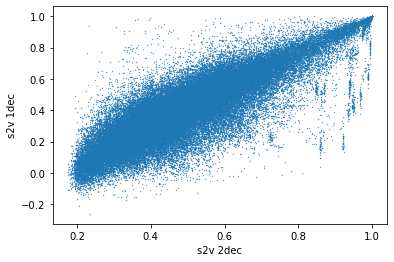

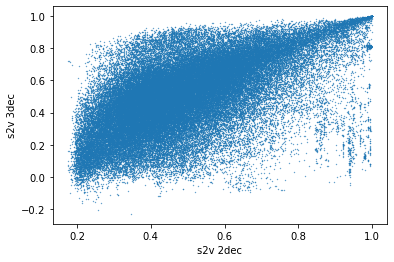

In [69]:
plt.scatter(dec2s, dec1s, s=0.1)
plt.xlabel('s2v 2dec')
plt.ylabel('s2v 1dec')
plt.show()

plt.scatter(dec2s, dec3s, s=0.1)
plt.xlabel('s2v 2dec')
plt.ylabel('s2v 3dec')
plt.show()

### Now the test set (new_and_unique2)

In [72]:
from spec2vec import SpectrumDocument

new_unique2_spec_ids = set([spec._obj.get("spectrumid") for spec in new_and_unique2_documents_query_s2v])

new_and_unique2_documents_library_s2v_1dec = []
new_and_unique2_documents_query_s2v_1dec = []
# new_and_unique2_documents_library_s2v_2dec = []
# new_and_unique2_documents_query_s2v_2dec = []
new_and_unique2_documents_library_s2v_3dec = []
new_and_unique2_documents_query_s2v_3dec = []

for spec in spectrums_s2v:
    spec_id = spec.get("spectrumid")

    if spec_id in new_unique2_spec_ids:
        new_and_unique2_documents_query_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
#         new_and_unique2_documents_query_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        new_and_unique2_documents_query_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))
    else:
        new_and_unique2_documents_library_s2v_1dec.append(SpectrumDocument(spec, n_decimals=1))
#         new_and_unique2_documents_library_s2v_2dec.append(SpectrumDocument(spec, n_decimals=2))
        new_and_unique2_documents_library_s2v_3dec.append(SpectrumDocument(spec, n_decimals=3))

In [73]:
outfile = os.path.join(path_data, 'testing_query_library_s2v_2dec.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        testing_query_library_s2v_2dec = pickle.load(inf)
        new_and_unique2_documents_query_s2v_2dec, new_and_unique2_documents_library_s2v_2dec = testing_query_library_s2v_2dec
else:
    with open(outfile, 'wb') as outf:
        testing_query_library_s2v_2dec = (new_and_unique2_documents_query_s2v_2dec, new_and_unique2_documents_library_s2v_2dec)
        pickle.dump(testing_query_library_s2v_2dec, outf)

C:\Users\joris\Documents\eScience_data\data\testing_query_library_s2v_2dec.pickle


In [74]:
outfile = os.path.join(path_data, 'new_and_unique2_found_matches_s2v_3_scores.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        new_and_unique2_found_matches_s2v_3_scores = pickle.load(inf)
else:
    topn = 40
    new_and_unique2_found_matches_s2v_3_scores = []
    for ID in range(len(new_and_unique2_documents_query_s2v_2dec)):
        topn_2dec = new_and_unique2_found_matches_s2v_2dec[ID].sort_values(by = 's2v_score', ascending=False).iloc[:topn].copy()
        lib_names_2dec = topn_2dec.index

        #1dec
        query_spec_1dec = [new_and_unique2_documents_query_s2v_1dec[ID]]
        lib_spec_1dec = [new_and_unique2_documents_library_s2v_1dec[lib_name] for lib_name in lib_names_2dec]
        query_spec_1dec_found_matches = library_matching(query_spec_1dec,
                                                         lib_spec_1dec,
                                                         model1,
                                                         presearch_based_on=["spec2vec-top{}".format(topn)],
                                                         ignore_non_annotated=True,
                                                         intensity_weighting_power=0.5,
                                                         allowed_missing_percentage=100,
                                                         cosine_tol=0.005,
                                                         mass_tolerance=1.0)
        #query_spec_1dec_found_matches have same order as topn_2dec
        s2v_score_1dec = list(query_spec_1dec_found_matches[0]['s2v_score'])
        topn_2dec['s2v_score_1dec'] = s2v_score_1dec

        #3dec
        query_spec_3dec = [new_and_unique2_documents_query_s2v_3dec[ID]]
        lib_spec_3dec = [new_and_unique2_documents_library_s2v_3dec[lib_name] for lib_name in lib_names_2dec]
        query_spec_3dec_found_matches = library_matching(query_spec_3dec,
                                                         lib_spec_3dec,
                                                         model3,
                                                         presearch_based_on=["spec2vec-top{}".format(topn)],
                                                         ignore_non_annotated=True,
                                                         intensity_weighting_power=0.5,
                                                         allowed_missing_percentage=100,
                                                         cosine_tol=0.005,
                                                         mass_tolerance=1.0)
        #query_spec_3dec_found_matches have same order as topn_2dec
        s2v_score_3dec = list(query_spec_3dec_found_matches[0]['s2v_score'])
        topn_2dec['s2v_score_3dec'] = s2v_score_3dec
        new_and_unique2_found_matches_s2v_3_scores.append(topn_2dec)
    
    #write to file
    with open(outfile, 'wb') as outf:
        pickle.dump(new_and_unique2_found_matches_s2v_3_scores, outf)

C:\Users\joris\Documents\eScience_data\data\new_and_unique2_found_matches_s2v_3_scores.pickle
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 62 word(s) missing in the model. Weighted fraction not covered is 8.79%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 7.08%.
Found 55 word(s) missing in the model. Weighted fraction not covered is 28.02%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.12%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 21 word(s) missing in the model. Weighted fraction not covered is 8.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.52%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model.

Pre-selection includes spec2vec top 40.
Found 72 word(s) missing in the model. Weighted fraction not covered is 8.17%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 5.44%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.35%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.98%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 6.22%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.91%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 4.37%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 2.55%.
Pre-selection includes spec2vec top 40.
Pre-selectio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 1.07%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 14 word(s) missing in the model. Weighted fraction not covered is 2.68%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 1.07%.
Found 12 word(s) missing in the model. Weighted fraction not covered is 2.66%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 12 word(s) missing in the model. Weighted fraction not covered is 2.27%.
Found 13 word(s) missing in the model. Weighted fraction not covered is 5.97%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 5.26%.
Pre-selection includes spec2vec top 40.
Pre-selectio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.74%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.53%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.13%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.85%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.35%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection 

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 98 word(s) missing in the model. Weighted fraction not covered is 19.12%.
Found 55 word(s) missing in the model. Weighted fraction not covered is 28.02%.
Found 66 word(s) missing in the model. Weighted fraction not covered is 23.47%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 62 word(s) missing in the model. Weighted fraction not covered is 8.79%.
Found 41 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Found 5 word(s) missing in the model. Weigh

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 16 word(s) missing in the model. Weighted fraction not covered is 10.37%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fra

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 3.93%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.01%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.45%.
Pre-selection includes spec2vec top 40.
Pre-select

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.38%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.86%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.26%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.69%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Found 3 word(s) missing in the model. Weighted fractio

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.19%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.43%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.48%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.13%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.23%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.27%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.32%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.24%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.85%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.74%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 31 word(s) missing in the model. Weighted fraction n

Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.65%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.74%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.61%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.39%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.68%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.60%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.84%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.36%.
Found 1 word(s) miss

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 13 word(s) missing in the model. Weighted fraction not covered is 4.16%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 3.98%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.26%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.74%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.70%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.87%.
Found 12 word(s) missing in the model. Weighted frac

Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.82%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.37%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.33%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.52%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.60%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.52%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.43%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.13%.
Pre-selection includ

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.35%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 3.08%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.78%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.63%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.42%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.39%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 1.72%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Found 3 word(s) missing in the model. Weighted fraction n

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.83%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.27%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.69%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.83%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.59%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.91%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.75%.
Found 3 word(s) missing in the model. Weighted fraction no

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.23%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.39%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.82%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.32%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.27%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.23%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.57%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.04%.
Pre-selection includes spec2vec top 40.
Pre-selection includ

Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.29%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.24%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.21%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.04%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.77%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.52%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Found 1 word(s) m

Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.62%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.84%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.87%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.20%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.37%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.93%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 18 word(s) missing in the model. Weighted fraction not covered is 6.49%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection i

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.16%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 16 word(s) missing in the model. Weighted fraction not covered is 10.37%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.98%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.49%.
Pre-selection includes spec2vec top 40.
Pre-selecti

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.24%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 1.03%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.24%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.13%.
Found 1 word(s) missing in the model. Weighted fracti

Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.14%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.30%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Found 22 word(s) missing in the model. Weighted fraction not covered is 5.35%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fracti

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 27 word(s) missing in the model. Weighted fraction not covered is 3.40%.
Found 41 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.23%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 3.47%.
Pre-selectio

Found 3 word(s) missing in the model. Weighted fraction not covered is 0.55%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.97%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.41%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 1.92%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 3.77%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction 

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.97%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.50%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 3.02%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.65%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.66%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.52%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.75%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction 

Found 5 word(s) missing in the model. Weighted fraction not covered is 1.76%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.17%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.85%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.12%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 0.83%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 0.91%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fractio

Found 2 word(s) missing in the model. Weighted fraction not covered is 0.44%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 15 word(s) missing in the model. Weighted fraction not covered is 4.78%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.26%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 2.96%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 3.03%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.91%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.96%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 8 word(s) missing in the model. Weighted fraction 

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.81%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 9 word(s) missing in the model. Weighted fraction not covered is 1.48%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.84%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 17 word(s) missing in the model. Weighted fraction not covered is 6.10%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.76%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 12 word(s) missing in the model. Weighted fr

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.58%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 27 word(s) missing in the model. Weighted fraction not covered is 3.40%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.82%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.79%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 16 word(s) missing in the model. Weighted fraction not covered is 5.27%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.93%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Pre-selectio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.97%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 3.88%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.95%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 

Found 18 word(s) missing in the model. Weighted fraction not covered is 10.71%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.48%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 5.84%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 41 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.23%.
Found 17 word(s) missing in the model. Weighted fraction not covered is 5.08%.
Found 10 word(s) missing in the model. Weighted fraction not covered is 2.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fra

Found 5 word(s) missing in the model. Weighted fraction not covered is 4.41%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 4.04%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.81%.
Found 17 word(s) missing in the model. Weighted fraction not covered is 5.08%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.72%.
Found 7 word(s) missing in the model. Weighted fraction not covered is 7.19%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.23%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.98%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 15 word(s) missing in the model. Weighted fraction

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.75%.
Found 18 word(s) missing in the model. Weighted fraction not covered is 3.99%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.31%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 5.64%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 72 word(s) missing in the model. Weighted fraction not covered is 8.17%.
Found 27 word(s) missing in the model. Weighted fraction not covered is 3.40%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.76%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.37%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 3.20%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 67 word(s) missing in the model. Weighted fracti

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 41 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.23%.
Found 23 word(s) missing in the model. Weighted fraction not covered is 6.52%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 2.42%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 7.08%.
Found 98 word(s) missing in the model. Weighted fraction not covered is 19.12%.
Found 62 word(s) missing in the model. Weighted fraction not covered is 8.79%.
Found 66 word(s) missing in the model. Weighted fr

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.26%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.00%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 1.06%.
Found 6 word(s) missing in the model. Weighted fraction not covered is 0.81%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 2.31%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 41 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 4.14%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.23%.
Found 8 word(s) missing in the model. Weighted fraction

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.61%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 3.98%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 15.79%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.65%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 3.67%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selec

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.79%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.72%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 41 word(s) missing in the model. Weighted fraction not covered is 6.12%.
Found 15 word(s) missing in the model. Weighted fraction not covered is 3.23%.
Found 24 word(s) missing in the model. Weighted fraction not covered is 7.63%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.26%.
Found 67 word(s) missing in the model. Weighted fraction not covered is 7.44%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.00%.
Pre-selectio

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 6 word(s) missing in the model. Weighted fraction not covered is 2.01%.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.35%.
Found 9 word(s) missing in the model. Weighted fraction not covered is 2.75%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.92%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 1.35%.
Found 11 word(s) missing in the model. Weighted fraction not covered is 2.44%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.72%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.78%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.57%.
Found 11 word(s) missing in the model. Weighted fraction 

Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.11%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.44%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.08%.
Pre-select

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.83%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.18%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 14 word(s) missing in the model. Weighted fraction not covered is 3.48%.
Pre-selection includes spec2vec top 40.
Pre-s

Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.29%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.13%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 

Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.22%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 5 word(s) missing in the model. Weighted fraction not covered is 14.81%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.30%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 7 word(s) missing in the model. Weighted fraction not covered is 1.76%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 1.03%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.57%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 3.62%.
Found 6 word(s)

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.11%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 16 word(s) missing in the model. Weighted fraction not covered is 4.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.43%.
Found 8 word(s) missing in the model. Weighted fraction not covered is 1.60%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selec

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.20%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.71%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 2.01%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.15%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-sele

Pre-selection includes spec2vec top 40.
Found 4 word(s) missing in the model. Weighted fraction not covered is 1.10%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 13 word(s) missing in the model. Weighted fraction not covered is 2.63%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.07%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-sel

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.62%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 7.24%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.38%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted

Found 3 word(s) missing in the model. Weighted fraction not covered is 1.66%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 98 word(s) missing in the model. Weighted fraction not covered is 19.12%.
Found 66 word(s) missing in the model. Weighted fraction not covered is 23.47%.
Found 55 word(s) missing in the model. Weighted fraction not covered is 28.02%.
Found 90 word(s) missing in the model. Weighted fraction not covered is 17.25%.
Found 49 word(s) missing in the model. Weighted fraction not covered is 13.16%.
Found 133 word(s) missing in the model. Weighted fraction not covered is 20.49%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 98 word(s) missing in the model. Weighted fraction not covered is 19.12%.
Found 66 word(s) missing in the model. Weig

Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 2 word(s) missing in the model. Weighted fraction not covered is 1.38%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 8 word(s) missing in the model. Weighted fraction not covered is 2.71%.
Pre-selection includes spec2vec top 40.
Pre-selection includes spec2vec top 40.
Found 17 word(s) missing in the model. Weighted fraction not covered is 11.35%.
Found 4 word(s) missing in the model. Weighted fraction not covered is 0.70%.
Found 4 word(s) missing in the model. Weighted f

## Adding other scores to prep for NN

In [3]:
import pickle
outfile = os.path.join(path_data, 'nn_prep_training_found_matches_s2v_3_scores.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_training_found_matches_s2v_3_scores = pickle.load(inf)
else:
    nn_prep_training_found_matches_s2v_3_scores = find_info_matches(old_and_unique_found_matches_s2v_3_scores, old_and_unique_documents_library_s2v_2dec, old_and_unique_documents_query_s2v_2dec)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_training_found_matches_s2v_3_scores, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_training_found_matches_s2v_3_scores.pickle


In [4]:
outfile = os.path.join(path_data, 'nn_prep_testing_found_matches_s2v_3_scores.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_prep_testing_found_matches_s2v_3_scores = pickle.load(inf)
else:
    nn_prep_testing_found_matches_s2v_3_scores = find_info_matches(new_and_unique2_found_matches_s2v_3_scores, new_and_unique2_documents_library_s2v_2dec, new_and_unique2_documents_query_s2v_2dec)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_prep_testing_found_matches_s2v_3_scores, outf)

C:\Users\joris\Documents\eScience_data\data\nn_prep_testing_found_matches_s2v_3_scores.pickle


In [8]:
#with top40
nn_training_found_matches_s2v_3_scores = make_s2v_selection(nn_prep_training_found_matches_s2v_3_scores, topn = 40)
nn_training_found_matches_s2v_3_scores.drop(['label'], axis = 1, inplace = True)

nn_testing_found_matches_s2v_3_scores = make_s2v_selection(nn_prep_testing_found_matches_s2v_3_scores, topn = 40)
nn_testing_found_matches_s2v_3_scores.drop(['label'], axis = 1, inplace = True)

In [9]:
testing_layers = [[10,1],
                  [10,24,1],
                  [10,48,1],
                  [24,48,1],
                  [48,48,1],
                  [10,96,1],
                  [10,24,10,1],
                  [10,48,10,1],
                  [10,24,48,1],
                  [10,24,48,1],
                  [10,24,48,10,1],
                  [10,24,48,24,10,1],
                  [10,24,24,24,10,1],
                  [10,24,24,24,24,10,1],
                  [10,24,24,24,24,24,10,1],
                  [10,24,24,48,24,24,10,1]]
base_model_name = os.path.join(path_data, 'NN_3_scores\\nn_2000_queries_3_scores_top40_layers')
models_testing_layers_top40_3_scores = []

X_tanimoto_3_scores_top40 = nn_training_found_matches_s2v_3_scores.drop('similarity', axis = 1)
y_tanimoto_3_scores_top40 = nn_training_found_matches_s2v_3_scores['similarity']
X_tanimoto_3_scores_top40_test = nn_testing_found_matches_s2v_3_scores.drop('similarity', axis = 1)
y_tanimoto_3_scores_top40_test = nn_testing_found_matches_s2v_3_scores['similarity']

for i, test_layers in enumerate(testing_layers):
    model_name_x = base_model_name + '_' + str(i)
    nn_2000_queries_3_scores_top40 = train_nn(X_tanimoto_3_scores_top40, y_tanimoto_3_scores_top40,
                                              X_tanimoto_3_scores_top40_test, y_tanimoto_3_scores_top40_test,
                                              layers = test_layers, model_loss = 'mean_squared_error',
                                              activations = 'relu', last_activation = None, model_epochs = 50,
                                              model_batch_size = 16, save_name = model_name_x)
    models_testing_layers_top40_3_scores.append(nn_2000_queries_3_scores_top40)

Train on 80000 samples
Epoch 1/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0709 - accuracy: 0.0654
Epoch 2/50
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0529 - accuracy: 0.0677
Epoch 3/50
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0514 - accuracy: 0.0681
Epoch 4/50
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0500 - accuracy: 0.0686
Epoch 5/50
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0494 - accuracy: 0.0686
Epoch 6/50
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0490 - accuracy: 0.0690
Epoch 7/50
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0487 - accuracy: 0.0692
Epoch 8/50
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0483 - accuracy: 0.0693
Epoch 9/50
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0481 - accuracy: 0.0694
Epoch 10/50
8

80000/80000 [==============================] - 8s 102us/sample - loss: 0.0447 - accuracy: 0.0703
Epoch 19/50
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0446 - accuracy: 0.0706
Epoch 20/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0446 - accuracy: 0.0703
Epoch 21/50
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0444 - accuracy: 0.0707
Epoch 22/50
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0443 - accuracy: 0.0708
Epoch 23/50
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0439 - accuracy: 0.0712
Epoch 24/50
80000/80000 [==============================] - 8s 106us/sample - loss: 0.0437 - accuracy: 0.0710
Epoch 25/50
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0436 - accuracy: 0.0713
Epoch 26/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0435 - accuracy: 0.0712
Epoch 27/50
80000/80000 [======

80000/80000 [==============================] - 8s 101us/sample - loss: 0.0428 - accuracy: 0.0710
Epoch 40/50
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0429 - accuracy: 0.0710
Epoch 41/50
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0428 - accuracy: 0.0712
Epoch 42/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0426 - accuracy: 0.0712
Epoch 43/50
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0427 - accuracy: 0.0712
Epoch 44/50
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0426 - accuracy: 0.0710
Epoch 45/50
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0427 - accuracy: 0.0711
Epoch 46/50
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0427 - accuracy: 0.0715
Epoch 47/50
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0426 - accuracy: 0.0713
Epoch 48/50
80000/80000 [==========

80000/80000 [==============================] - 8s 101us/sample - loss: 0.0436 - accuracy: 0.0709
Epoch 7/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0431 - accuracy: 0.0710
Epoch 8/50
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0428 - accuracy: 0.0710
Epoch 9/50
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0423 - accuracy: 0.0712
Epoch 10/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0419 - accuracy: 0.0714
Epoch 11/50
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0417 - accuracy: 0.0714
Epoch 12/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0413 - accuracy: 0.0716
Epoch 13/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0411 - accuracy: 0.0720
Epoch 14/50
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0410 - accuracy: 0.0720
Epoch 15/50
80000/80000 [=========

80000/80000 [==============================] - 7s 92us/sample - loss: 0.0433 - accuracy: 0.0708
Epoch 28/50
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0433 - accuracy: 0.0710
Epoch 29/50
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0433 - accuracy: 0.0709
Epoch 30/50
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0432 - accuracy: 0.0711
Epoch 31/50
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0432 - accuracy: 0.0712
Epoch 32/50
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0431 - accuracy: 0.0711
Epoch 33/50
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0430 - accuracy: 0.0712
Epoch 34/50
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0430 - accuracy: 0.0711
Epoch 35/50
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0429 - accuracy: 0.0708
Epoch 36/50
80000/80000 [===============

80000/80000 [==============================] - 8s 104us/sample - loss: 0.0418 - accuracy: 0.0713
Epoch 49/50
80000/80000 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.07 - 8s 104us/sample - loss: 0.0418 - accuracy: 0.0715
Epoch 50/50
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0416 - accuracy: 0.0718
Training loss: 0.0416

80000/80000 [==============================] - 3s 32us/sample - loss: 0.0435 - accuracy: 0.0680
Test accuracy: 6.80
Test loss: 0.0435
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_6
INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_6\assets
Train on 80000 samples
Epoch 1/50
80000/80000 [==============================] - 10s 121us/sample - loss: 0.0545 - accuracy: 0.0675
Epoch 2/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0498 - accuracy: 0.

80000/80000 [==============================] - 9s 111us/sample - loss: 0.0430 - accuracy: 0.0715
Epoch 16/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0428 - accuracy: 0.0715
Epoch 17/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0427 - accuracy: 0.0715
Epoch 18/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0425 - accuracy: 0.0716
Epoch 19/50
80000/80000 [==============================] - 9s 110us/sample - loss: 0.0425 - accuracy: 0.0713
Epoch 20/50
80000/80000 [==============================] - 9s 118us/sample - loss: 0.0423 - accuracy: 0.0717
Epoch 21/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0421 - accuracy: 0.0716
Epoch 22/50
80000/80000 [==============================] - 9s 106us/sample - loss: 0.0421 - accuracy: 0.0717
Epoch 23/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0420 - accuracy: 0.0716
Epoch 24/50
80000/80000 [======

80000/80000 [==============================] - 8s 105us/sample - loss: 0.0418 - accuracy: 0.0707
Epoch 37/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0417 - accuracy: 0.0709
Epoch 38/50
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0417 - accuracy: 0.0710
Epoch 39/50
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0417 - accuracy: 0.0710
Epoch 40/50
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0416 - accuracy: 0.0712
Epoch 41/50
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0415 - accuracy: 0.0712
Epoch 42/50
80000/80000 [==============================] - 9s 106us/sample - loss: 0.0415 - accuracy: 0.0711
Epoch 43/50
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0415 - accuracy: 0.0710
Epoch 44/50
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0414 - accuracy: 0.0708
Epoch 45/50
80000/80000 [======

80000/80000 [==============================] - 9s 108us/sample - loss: 0.0476 - accuracy: 0.0696
Epoch 4/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0468 - accuracy: 0.0697
Epoch 5/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0460 - accuracy: 0.0696
Epoch 6/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0455 - accuracy: 0.0694
Epoch 7/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0451 - accuracy: 0.0697
Epoch 8/50
80000/80000 [==============================] - 9s 109us/sample - loss: 0.0448 - accuracy: 0.0698
Epoch 9/50
80000/80000 [==============================] - 9s 113us/sample - loss: 0.0444 - accuracy: 0.0696
Epoch 10/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0443 - accuracy: 0.0703
Epoch 11/50
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0440 - accuracy: 0.0700
Epoch 12/50
80000/80000 [============

80000/80000 [==============================] - 9s 110us/sample - loss: 0.0414 - accuracy: 0.0716
Epoch 25/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0413 - accuracy: 0.0714
Epoch 26/50
80000/80000 [==============================] - 9s 106us/sample - loss: 0.0412 - accuracy: 0.0721
Epoch 27/50
80000/80000 [==============================] - 9s 109us/sample - loss: 0.0412 - accuracy: 0.0715
Epoch 28/50
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0411 - accuracy: 0.0716
Epoch 29/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0410 - accuracy: 0.0718
Epoch 30/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0409 - accuracy: 0.0719
Epoch 31/50
80000/80000 [==============================] - 9s 109us/sample - loss: 0.0408 - accuracy: 0.0719
Epoch 32/50
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0409 - accuracy: 0.0720
Epoch 33/50
80000/80000 [======

80000/80000 [==============================] - 10s 122us/sample - loss: 0.0415 - accuracy: 0.0706
Epoch 46/50
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0414 - accuracy: 0.0707
Epoch 47/50
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0414 - accuracy: 0.0710
Epoch 48/50
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0413 - accuracy: 0.0707
Epoch 49/50
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0413 - accuracy: 0.0709
Epoch 50/50
80000/80000 [==============================] - 10s 123us/sample - loss: 0.0412 - accuracy: 0.0710
Training loss: 0.0412

80000/80000 [==============================] - 3s 35us/sample - loss: 0.0449 - accuracy: 0.0657
Test accuracy: 6.57
Test loss: 0.0449
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_13
INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN

80000/80000 [==============================] - 9s 114us/sample - loss: 0.0446 - accuracy: 0.0700
Epoch 12/50
80000/80000 [==============================] - 9s 116us/sample - loss: 0.0443 - accuracy: 0.0701
Epoch 13/50
80000/80000 [==============================] - 9s 115us/sample - loss: 0.0442 - accuracy: 0.0702
Epoch 14/50
80000/80000 [==============================] - 9s 115us/sample - loss: 0.0440 - accuracy: 0.0705
Epoch 15/50
80000/80000 [==============================] - 9s 114us/sample - loss: 0.0438 - accuracy: 0.0702
Epoch 16/50
80000/80000 [==============================] - 10s 121us/sample - loss: 0.0437 - accuracy: 0.0704
Epoch 17/50
80000/80000 [==============================] - 10s 119us/sample - loss: 0.0435 - accuracy: 0.0702
Epoch 18/50
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0434 - accuracy: 0.0702
Epoch 19/50
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0433 - accuracy: 0.0702
Epoch 20/50
80000/80000 [====

In [27]:
accept = 0.001
best = (1,1,1)
for i, mdl in enumerate(models_testing_layers_top40_3_scores):
    if abs(mdl[1]['loss'][-1] - mdl[-1]) <= accept:
        if mdl[-1] < best[-1]:
            best = (i, mdl[1]['loss'][-1], mdl[-1])
    print('Model {}\tTraining loss {}\tTesting loss {}'.format(i, mdl[1]['loss'][-1], mdl[-1]))

print('\nBest:\nModel {}\tTraining loss {}\tTesting loss {}'.format(best[0],best[1],best[2]))

Model 0	Training loss 0.04601224814709276	Testing loss 0.04675640141982585
Model 1	Training loss 0.04230995469866321	Testing loss 0.044387400468532
Model 2	Training loss 0.04244906674139202	Testing loss 0.0455046233932022
Model 3	Training loss 0.03994138687858358	Testing loss 0.043151313790970015
Model 4	Training loss 0.03810193138960749	Testing loss 0.04323336895329412
Model 5	Training loss 0.042362451211735604	Testing loss 0.04447712193026673
Model 6	Training loss 0.041644893439952285	Testing loss 0.04352740124827251
Model 7	Training loss 0.040314399206731466	Testing loss 0.04317946283458732
Model 8	Training loss 0.04056220244448632	Testing loss 0.04315483807502314
Model 9	Training loss 0.041156949339155105	Testing loss 0.04505357890985906
Model 10	Training loss 0.04056789578394964	Testing loss 0.0445665597314015
Model 11	Training loss 0.03995043369214982	Testing loss 0.04551459573339671
Model 12	Training loss 0.03982361100660637	Testing loss 0.04311452289000153
Model 13	Training los

In [11]:
testing_layers = [[8,1],
                  [10,1],
                  [16,1],
                  [24,1],
                  [48,1],
                  [8,8,1],
                  [10,10,1],
                  [16,16,1],
                  [24,24,1],
                  [10,24,1],
                  [10,48,1],
                  [24,48,1],
                  [48,48,1],
                  [10,96,1],
                  [8,8,8,1],
                  [10,10,10,1],
                  [10,24,10,1],
                  [24,24,24,1],
                  [10,48,10,1],
                  [10,24,48,1],
                  [10,24,48,1],
                  [10,24,48,10,1],
                  [10,24,48,24,10,1],
                  [10,24,24,24,10,1],
                  [10,24,24,24,24,10,1],
                  [10,24,24,24,24,24,10,1],
                  [10,24,24,48,24,24,10,1]]
base_model_name = os.path.join(path_data, 'NN_3_scores\\nn_2000_queries_3_scores_top40_layers_30epochs')
models_testing_layers_top40_3_scores_30eps = []

X_tanimoto_3_scores_top40 = nn_training_found_matches_s2v_3_scores.drop('similarity', axis = 1)
y_tanimoto_3_scores_top40 = nn_training_found_matches_s2v_3_scores['similarity']
X_tanimoto_3_scores_top40_test = nn_testing_found_matches_s2v_3_scores.drop('similarity', axis = 1)
y_tanimoto_3_scores_top40_test = nn_testing_found_matches_s2v_3_scores['similarity']

for i, test_layers in enumerate(testing_layers):
    model_name_x = base_model_name + '_' + str(i)
    nn_2000_queries_3_scores_top40 = train_nn(X_tanimoto_3_scores_top40, y_tanimoto_3_scores_top40,
                                              X_tanimoto_3_scores_top40_test, y_tanimoto_3_scores_top40_test,
                                              layers = test_layers, model_loss = 'mean_squared_error',
                                              activations = 'relu', last_activation = None, model_epochs = 30,
                                              model_batch_size = 16, save_name = model_name_x)
    models_testing_layers_top40_3_scores_30eps.append(nn_2000_queries_3_scores_top40)

Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0548 - accuracy: 0.0694
Epoch 2/30
80000/80000 [==============================] - 7s 94us/sample - loss: 0.0515 - accuracy: 0.0701
Epoch 3/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0505 - accuracy: 0.0696
Epoch 4/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0498 - accuracy: 0.0694
Epoch 5/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0493 - accuracy: 0.0698
Epoch 6/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0489 - accuracy: 0.0698
Epoch 7/30
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0485 - accuracy: 0.0699
Epoch 8/30
80000/80000 [==============================] - 9s 114us/sample - loss: 0.0483 - accuracy: 0.0699
Epoch 9/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0481 - accuracy: 0.0701
Epoch 10/30

80000/80000 [==============================] - 6s 81us/sample - loss: 0.0485 - accuracy: 0.0701
Epoch 9/30
80000/80000 [==============================] - 7s 81us/sample - loss: 0.0483 - accuracy: 0.0701
Epoch 10/30
80000/80000 [==============================] - 6s 81us/sample - loss: 0.0483 - accuracy: 0.0701
Epoch 11/30
80000/80000 [==============================] - 6s 80us/sample - loss: 0.0480 - accuracy: 0.0703
Epoch 12/30
80000/80000 [==============================] - 7s 81us/sample - loss: 0.0478 - accuracy: 0.0703
Epoch 13/30
80000/80000 [==============================] - 6s 81us/sample - loss: 0.0477 - accuracy: 0.0706
Epoch 14/30
80000/80000 [==============================] - 7s 81us/sample - loss: 0.0475 - accuracy: 0.0708
Epoch 15/30
80000/80000 [==============================] - 6s 81us/sample - loss: 0.0475 - accuracy: 0.0709
Epoch 16/30
80000/80000 [==============================] - 7s 83us/sample - loss: 0.0473 - accuracy: 0.0708
Epoch 17/30
80000/80000 [================

80000/80000 [==============================] - 7s 90us/sample - loss: 0.0436 - accuracy: 0.0718
Epoch 16/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0435 - accuracy: 0.0718
Epoch 17/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0435 - accuracy: 0.0721
Epoch 18/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0434 - accuracy: 0.0722
Epoch 19/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0433 - accuracy: 0.0718
Epoch 20/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0432 - accuracy: 0.0718
Epoch 21/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0432 - accuracy: 0.0719
Epoch 22/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0432 - accuracy: 0.0723
Epoch 23/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0431 - accuracy: 0.0721
Epoch 24/30
80000/80000 [===============

80000/80000 [==============================] - 8s 94us/sample - loss: 0.0455 - accuracy: 0.0705
Epoch 23/30
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0454 - accuracy: 0.0704
Epoch 24/30
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0454 - accuracy: 0.0702
Epoch 25/30
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0453 - accuracy: 0.0704
Epoch 26/30
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0453 - accuracy: 0.0704
Epoch 27/30
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0453 - accuracy: 0.0707
Epoch 28/30
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0452 - accuracy: 0.0703
Epoch 29/30
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0451 - accuracy: 0.0705
Epoch 30/30
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0451 - accuracy: 0.0706
Training loss: 0.0451

80000/80000 [====

80000/80000 [==============================] - 7s 90us/sample - loss: 0.0413 - accuracy: 0.0718
Epoch 30/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0412 - accuracy: 0.0718
Training loss: 0.0412

80000/80000 [==============================] - 2s 29us/sample - loss: 0.0433 - accuracy: 0.0681
Test accuracy: 6.81
Test loss: 0.0433
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_30epochs_8
INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_30epochs_8\assets
Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0553 - accuracy: 0.0663
Epoch 2/30
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0511 - accuracy: 0.0684
Epoch 3/30
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0497 - accuracy: 0.0692
Epoch 4/30
80000/80000 [==

80000/80000 [==============================] - 8s 98us/sample - loss: 0.0543 - accuracy: 0.0676
Epoch 2/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0489 - accuracy: 0.0686
Epoch 3/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0468 - accuracy: 0.0694
Epoch 4/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0454 - accuracy: 0.0708
Epoch 5/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0445 - accuracy: 0.0708
Epoch 6/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0440 - accuracy: 0.0712
Epoch 7/30
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0438 - accuracy: 0.0714
Epoch 8/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0435 - accuracy: 0.0715
Epoch 9/30
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0431 - accuracy: 0.0716
Epoch 10/30
80000/80000 [=======================

80000/80000 [==============================] - 7s 91us/sample - loss: 0.0460 - accuracy: 0.0704
Epoch 9/30
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0457 - accuracy: 0.0705
Epoch 10/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0454 - accuracy: 0.0704
Epoch 11/30
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0451 - accuracy: 0.0707
Epoch 12/30
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0447 - accuracy: 0.0706
Epoch 13/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0444 - accuracy: 0.0705
Epoch 14/30
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0443 - accuracy: 0.0710
Epoch 15/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0441 - accuracy: 0.0710
Epoch 16/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0438 - accuracy: 0.0710
Epoch 17/30
80000/80000 [================

80000/80000 [==============================] - 7s 92us/sample - loss: 0.0458 - accuracy: 0.0706
Epoch 16/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0457 - accuracy: 0.0704
Epoch 17/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0457 - accuracy: 0.0703
Epoch 18/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0455 - accuracy: 0.0706
Epoch 19/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0455 - accuracy: 0.0704
Epoch 20/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0453 - accuracy: 0.0704
Epoch 21/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0453 - accuracy: 0.0703
Epoch 22/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0452 - accuracy: 0.0704
Epoch 23/30
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0452 - accuracy: 0.0704
Epoch 24/30
80000/80000 [===============

80000/80000 [==============================] - 8s 100us/sample - loss: 0.0410 - accuracy: 0.0719
Epoch 23/30
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0409 - accuracy: 0.0720
Epoch 24/30
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0409 - accuracy: 0.0716
Epoch 25/30
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0407 - accuracy: 0.0719
Epoch 26/30
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0406 - accuracy: 0.0718
Epoch 27/30
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0406 - accuracy: 0.0721
Epoch 28/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0405 - accuracy: 0.0719
Epoch 29/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0405 - accuracy: 0.0718
Epoch 30/30
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0403 - accuracy: 0.0719
Training loss: 0.0403

80000/80000 [=

80000/80000 [==============================] - 8s 99us/sample - loss: 0.0421 - accuracy: 0.0707
Epoch 30/30
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0421 - accuracy: 0.0709
Training loss: 0.0421

80000/80000 [==============================] - 2s 29us/sample - loss: 0.0452 - accuracy: 0.0682
Test accuracy: 6.82
Test loss: 0.0452
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_30epochs_19
INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_30epochs_19\assets
Train on 80000 samples
Epoch 1/30
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0544 - accuracy: 0.0677
Epoch 2/30
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0497 - accuracy: 0.0686
Epoch 3/30
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0482 - accuracy: 0.0690
Epoch 4/30
80000/80000

80000/80000 [==============================] - 9s 119us/sample - loss: 0.0486 - accuracy: 0.0697
Epoch 3/30
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0472 - accuracy: 0.0699
Epoch 4/30
80000/80000 [==============================] - 10s 130us/sample - loss: 0.0465 - accuracy: 0.0699
Epoch 5/30
80000/80000 [==============================] - 12s 147us/sample - loss: 0.0461 - accuracy: 0.0698
Epoch 6/30
80000/80000 [==============================] - 10s 128us/sample - loss: 0.0458 - accuracy: 0.0700
Epoch 7/30
80000/80000 [==============================] - 10s 119us/sample - loss: 0.0453 - accuracy: 0.0698
Epoch 8/30
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0449 - accuracy: 0.0700
Epoch 9/30
80000/80000 [==============================] - 10s 121us/sample - loss: 0.0447 - accuracy: 0.0701
Epoch 10/30
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0444 - accuracy: 0.0704
Epoch 11/30
80000/80000 [========

Epoch 9/30
80000/80000 [==============================] - 10s 123us/sample - loss: 0.0452 - accuracy: 0.0700
Epoch 10/30
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0449 - accuracy: 0.0705
Epoch 11/30
80000/80000 [==============================] - 10s 121us/sample - loss: 0.0446 - accuracy: 0.0701
Epoch 12/30
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0442 - accuracy: 0.0702
Epoch 13/30
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0441 - accuracy: 0.0701
Epoch 14/30
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0440 - accuracy: 0.0704
Epoch 15/30
80000/80000 [==============================] - 10s 124us/sample - loss: 0.0437 - accuracy: 0.0707
Epoch 16/30
80000/80000 [==============================] - 10s 124us/sample - loss: 0.0435 - accuracy: 0.0705
Epoch 17/30
80000/80000 [==============================] - 10s 122us/sample - loss: 0.0434 - accuracy: 0.0706
Epoch 18/30

80000/80000 [==============================] - 9s 116us/sample - loss: 0.0439 - accuracy: 0.0704
Epoch 16/30
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0439 - accuracy: 0.0702
Epoch 17/30
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0436 - accuracy: 0.0704
Epoch 18/30
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0435 - accuracy: 0.0706
Epoch 19/30
80000/80000 [==============================] - 9s 116us/sample - loss: 0.0432 - accuracy: 0.0702
Epoch 20/30
80000/80000 [==============================] - 9s 114us/sample - loss: 0.0433 - accuracy: 0.0704
Epoch 21/30
80000/80000 [==============================] - 9s 116us/sample - loss: 0.0431 - accuracy: 0.0704
Epoch 22/30
80000/80000 [==============================] - 10s 129us/sample - loss: 0.0428 - accuracy: 0.0704
Epoch 23/30
80000/80000 [==============================] - 9s 116us/sample - loss: 0.0429 - accuracy: 0.0704
Epoch 24/30
80000/80000 [=====

In [26]:
accept = 0.001
best = (1,1,1)
for i, mdl in enumerate(models_testing_layers_top40_3_scores_30eps):
    if abs(mdl[1]['loss'][-1] - mdl[-1]) <= accept:
        if mdl[-1] < best[-1]:
            best = (i, mdl[1]['loss'][-1], mdl[-1])
    print('Model {}\tTraining loss {}\tTesting loss {}'.format(i, mdl[1]['loss'][-1], mdl[-1]))

print('\nBest:\nModel {}\tTraining loss {}\tTesting loss {}'.format(best[0],best[1],best[2]))

Model 0	Training loss 0.04648438331754878	Testing loss 0.046977700048498806
Model 1	Training loss 0.04617467442881316	Testing loss 0.04793423302937299
Model 2	Training loss 0.04543129180353135	Testing loss 0.046603637968562546
Model 3	Training loss 0.04408772497586906	Testing loss 0.045557090504374356
Model 4	Training loss 0.04264649275410921	Testing loss 0.04455735810156912
Model 5	Training loss 0.045167771598510445	Testing loss 0.04667908964068629
Model 6	Training loss 0.04513686922751367	Testing loss 0.046376673617307095
Model 7	Training loss 0.04374446601318195	Testing loss 0.045001061017951
Model 8	Training loss 0.04117589251631871	Testing loss 0.04326788399950601
Model 9	Training loss 0.04421400652807206	Testing loss 0.04592623066632077
Model 10	Training loss 0.04296832676539197	Testing loss 0.04480195764312521
Model 11	Training loss 0.04056670952495187	Testing loss 0.043383096495363864
Model 12	Training loss 0.03944555655643344	Testing loss 0.04271712246933021
Model 13	Training 

In [14]:
testing_layers = [[6,1],
                  [8,1],
                  [10,1],
                  [16,1],
                  [24,1],
                  [48,1],
                  [6,6,1],
                  [8,8,1],
                  [10,10,1],
                  [16,16,1],
                  [24,24,1],
                  [10,24,1],
                  [10,48,1],
                  [24,48,1],
                  [48,48,1],
                  [10,96,1],
                  [6,6,6,1],
                  [8,8,8,1],
                  [10,10,10,1],
                  [10,24,10,1],
                  [24,24,24,1],
                  [10,48,10,1],
                  [10,24,48,1],
                  [10,24,48,1],
                  [6,6,6,6,1],
                  [8,8,8,8,1],
                  [6,6,6,6,6,1],
                  [6,6,6,6,6,6,1]]
base_model_name = os.path.join(path_data, 'NN_3_scores\\nn_2000_queries_3_scores_top40_layers_40epochs')
models_testing_layers_top40_3_scores_40eps = []

X_tanimoto_3_scores_top40 = nn_training_found_matches_s2v_3_scores.drop('similarity', axis = 1)
y_tanimoto_3_scores_top40 = nn_training_found_matches_s2v_3_scores['similarity']
X_tanimoto_3_scores_top40_test = nn_testing_found_matches_s2v_3_scores.drop('similarity', axis = 1)
y_tanimoto_3_scores_top40_test = nn_testing_found_matches_s2v_3_scores['similarity']

for i, test_layers in enumerate(testing_layers):
    model_name_x = base_model_name + '_' + str(i)
    nn_2000_queries_3_scores_top40 = train_nn(X_tanimoto_3_scores_top40, y_tanimoto_3_scores_top40,
                                              X_tanimoto_3_scores_top40_test, y_tanimoto_3_scores_top40_test,
                                              layers = test_layers, model_loss = 'mean_squared_error',
                                              activations = 'relu', last_activation = None, model_epochs = 40,
                                              model_batch_size = 16, save_name = model_name_x)
    models_testing_layers_top40_3_scores_40eps.append(nn_2000_queries_3_scores_top40)

Train on 80000 samples
Epoch 1/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0586 - accuracy: 0.0664
Epoch 2/40
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0527 - accuracy: 0.0697
Epoch 3/40
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0518 - accuracy: 0.0702
Epoch 4/40
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0515 - accuracy: 0.0699
Epoch 5/40
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0512 - accuracy: 0.0698
Epoch 6/40
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0510 - accuracy: 0.0697
Epoch 7/40
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0508 - accuracy: 0.0698
Epoch 8/40
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0504 - accuracy: 0.0697
Epoch 9/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0502 - accuracy: 0.0699
Epoch 10/40

80000/80000 [==============================] - 7s 92us/sample - loss: 0.0455 - accuracy: 0.0717
Epoch 33/40
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0456 - accuracy: 0.0716
Epoch 34/40
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0455 - accuracy: 0.0716
Epoch 35/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0455 - accuracy: 0.0717
Epoch 36/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0455 - accuracy: 0.0716
Epoch 37/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0455 - accuracy: 0.0718
Epoch 38/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0454 - accuracy: 0.0719
Epoch 39/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0454 - accuracy: 0.0717
Epoch 40/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0454 - accuracy: 0.0716
Training loss: 0.0454

80000/80000 [====

80000/80000 [==============================] - 7s 90us/sample - loss: 0.0453 - accuracy: 0.0708
Epoch 20/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0452 - accuracy: 0.0708
Epoch 21/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0451 - accuracy: 0.0706
Epoch 22/40
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0450 - accuracy: 0.0712
Epoch 23/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0449 - accuracy: 0.0711
Epoch 24/40
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0448 - accuracy: 0.0710
Epoch 25/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0448 - accuracy: 0.0712
Epoch 26/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0447 - accuracy: 0.0713
Epoch 27/40
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0446 - accuracy: 0.0713
Epoch 28/40
80000/80000 [===============

80000/80000 [==============================] - 7s 87us/sample - loss: 0.0462 - accuracy: 0.0706
Epoch 7/40
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0455 - accuracy: 0.0708
Epoch 8/40
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0448 - accuracy: 0.0715
Epoch 9/40
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0445 - accuracy: 0.0718
Epoch 10/40
80000/80000 [==============================] - 7s 89us/sample - loss: 0.0442 - accuracy: 0.0716
Epoch 11/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0440 - accuracy: 0.0716
Epoch 12/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0439 - accuracy: 0.0718
Epoch 13/40
80000/80000 [==============================] - 7s 87us/sample - loss: 0.0437 - accuracy: 0.0716
Epoch 14/40
80000/80000 [==============================] - 7s 88us/sample - loss: 0.0436 - accuracy: 0.0716
Epoch 15/40
80000/80000 [==================

80000/80000 [==============================] - 7s 88us/sample - loss: 0.0453 - accuracy: 0.0708
Epoch 38/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0453 - accuracy: 0.0707
Epoch 39/40
80000/80000 [==============================] - 7s 86us/sample - loss: 0.0453 - accuracy: 0.0709
Epoch 40/40
80000/80000 [==============================] - 7s 90us/sample - loss: 0.0453 - accuracy: 0.0709
Training loss: 0.0453

80000/80000 [==============================] - 2s 29us/sample - loss: 0.0463 - accuracy: 0.0673
Test accuracy: 6.73
Test loss: 0.0463
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_40epochs_6
INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_40epochs_6\assets
Train on 80000 samples
Epoch 1/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0595 - accuracy: 0.0682
Epoch 2/40
80000/80000 [

Epoch 24/40
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0453 - accuracy: 0.0705
Epoch 25/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0452 - accuracy: 0.0709
Epoch 26/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0452 - accuracy: 0.0706
Epoch 27/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0452 - accuracy: 0.0706
Epoch 28/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0452 - accuracy: 0.0706
Epoch 29/40
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0451 - accuracy: 0.0706
Epoch 30/40
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0451 - accuracy: 0.0708
Epoch 31/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0450 - accuracy: 0.0706
Epoch 32/40
80000/80000 [==============================] - 7s 92us/sample - loss: 0.0450 - accuracy: 0.0705
Epoch 33/40
80000/80000 [=

80000/80000 [==============================] - 9s 109us/sample - loss: 0.0433 - accuracy: 0.0716
Epoch 12/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0432 - accuracy: 0.0715
Epoch 13/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0430 - accuracy: 0.0717
Epoch 14/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0427 - accuracy: 0.0719
Epoch 15/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0426 - accuracy: 0.0718
Epoch 16/40
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0425 - accuracy: 0.0717
Epoch 17/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0425 - accuracy: 0.0717
Epoch 18/40
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0425 - accuracy: 0.0718
Epoch 19/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0423 - accuracy: 0.0716
Epoch 20/40
80000/80000 [==========

INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_40epochs_11\assets
Train on 80000 samples
Epoch 1/40
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0543 - accuracy: 0.0688
Epoch 2/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0492 - accuracy: 0.0692
Epoch 3/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0480 - accuracy: 0.0696
Epoch 4/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0470 - accuracy: 0.0698
Epoch 5/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0465 - accuracy: 0.0705
Epoch 6/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0463 - accuracy: 0.0703
Epoch 7/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0459 - accuracy: 0.0703
Epoch 8/40
80000/80000 [==============================] - 8s 100us/sample -

80000/80000 [==============================] - 9s 108us/sample - loss: 0.0414 - accuracy: 0.0710
Epoch 31/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0413 - accuracy: 0.0708
Epoch 32/40
80000/80000 [==============================] - 8s 106us/sample - loss: 0.0412 - accuracy: 0.0711
Epoch 33/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0412 - accuracy: 0.0712
Epoch 34/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0411 - accuracy: 0.0709
Epoch 35/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0411 - accuracy: 0.0711
Epoch 36/40
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0410 - accuracy: 0.0711
Epoch 37/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0409 - accuracy: 0.0709
Epoch 38/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0410 - accuracy: 0.0711
Epoch 39/40
80000/80000 [============

80000/80000 [==============================] - 8s 100us/sample - loss: 0.0429 - accuracy: 0.0714
Epoch 18/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0428 - accuracy: 0.0716
Epoch 19/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0426 - accuracy: 0.0718
Epoch 20/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0426 - accuracy: 0.0718
Epoch 21/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0425 - accuracy: 0.0718
Epoch 22/40
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0424 - accuracy: 0.0715
Epoch 23/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0422 - accuracy: 0.0716
Epoch 24/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0421 - accuracy: 0.0719
Epoch 25/40
80000/80000 [==============================] - 9s 109us/sample - loss: 0.0422 - accuracy: 0.0716
Epoch 26/40
80000/80000 [=========

80000/80000 [==============================] - 8s 97us/sample - loss: 0.0491 - accuracy: 0.0690
Epoch 5/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0486 - accuracy: 0.0693
Epoch 6/40
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0481 - accuracy: 0.0694
Epoch 7/40
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0478 - accuracy: 0.0693
Epoch 8/40
80000/80000 [==============================] - 8s 96us/sample - loss: 0.0475 - accuracy: 0.0694
Epoch 9/40
80000/80000 [==============================] - 8s 95us/sample - loss: 0.0473 - accuracy: 0.0695
Epoch 10/40
80000/80000 [==============================] - 7s 91us/sample - loss: 0.0470 - accuracy: 0.0697
Epoch 11/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0468 - accuracy: 0.0697
Epoch 12/40
80000/80000 [==============================] - 7s 93us/sample - loss: 0.0466 - accuracy: 0.0699
Epoch 13/40
80000/80000 [====================

80000/80000 [==============================] - 10s 125us/sample - loss: 0.0444 - accuracy: 0.0706- loss: 0.0444 - accuracy
Epoch 36/40
80000/80000 [==============================] - 9s 106us/sample - loss: 0.0444 - accuracy: 0.0704
Epoch 37/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0444 - accuracy: 0.0707
Epoch 38/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0444 - accuracy: 0.0705
Epoch 39/40
80000/80000 [==============================] - 8s 99us/sample - loss: 0.0443 - accuracy: 0.0706
Epoch 40/40
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0443 - accuracy: 0.0704
Training loss: 0.0443

80000/80000 [==============================] - 2s 31us/sample - loss: 0.0457 - accuracy: 0.0679
Test accuracy: 6.79
Test loss: 0.0457
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_40epochs_18
INFO:tensorflow:Assets written to: C:\Users\joris\Docu

80000/80000 [==============================] - 8s 98us/sample - loss: 0.0415 - accuracy: 0.0716
Epoch 22/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0414 - accuracy: 0.0715
Epoch 23/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0412 - accuracy: 0.0716
Epoch 24/40
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0412 - accuracy: 0.0716
Epoch 25/40
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0412 - accuracy: 0.0715
Epoch 26/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0410 - accuracy: 0.0716
Epoch 27/40
80000/80000 [==============================] - 8s 100us/sample - loss: 0.0410 - accuracy: 0.0714
Epoch 28/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0409 - accuracy: 0.0717
Epoch 29/40
80000/80000 [==============================] - 9s 115us/sample - loss: 0.0407 - accuracy: 0.0715
Epoch 30/40
80000/80000 [=======

80000/80000 [==============================] - 11s 137us/sample - loss: 0.0451 - accuracy: 0.0703
Epoch 9/40
80000/80000 [==============================] - 8s 105us/sample - loss: 0.0450 - accuracy: 0.0704
Epoch 10/40
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0448 - accuracy: 0.0701
Epoch 11/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0446 - accuracy: 0.0703
Epoch 12/40
80000/80000 [==============================] - 8s 101us/sample - loss: 0.0444 - accuracy: 0.0704
Epoch 13/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0442 - accuracy: 0.0706
Epoch 14/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0441 - accuracy: 0.0704
Epoch 15/40
80000/80000 [==============================] - 9s 108us/sample - loss: 0.0439 - accuracy: 0.0705
Epoch 16/40
80000/80000 [==============================] - 8s 103us/sample - loss: 0.0437 - accuracy: 0.0707
Epoch 17/40
80000/80000 [======

80000/80000 [==============================] - 8s 103us/sample - loss: 0.0420 - accuracy: 0.0715
Epoch 40/40
80000/80000 [==============================] - 8s 104us/sample - loss: 0.0419 - accuracy: 0.0713
Training loss: 0.0419

80000/80000 [==============================] - 3s 32us/sample - loss: 0.0447 - accuracy: 0.0685
Test accuracy: 6.85
Test loss: 0.0447
Saving model at: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_40epochs_23
INFO:tensorflow:Assets written to: C:\Users\joris\Documents\eScience_data\data\NN_3_scores\nn_2000_queries_3_scores_top40_layers_40epochs_23\assets
Train on 80000 samples
Epoch 1/40
80000/80000 [==============================] - 9s 106us/sample - loss: 0.0610 - accuracy: 0.0669
Epoch 2/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0515 - accuracy: 0.0688
Epoch 3/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0501 - accuracy: 0.0691
Epoch 4/40
80000/800

80000/80000 [==============================] - 10s 122us/sample - loss: 0.0452 - accuracy: 0.0701
Epoch 27/40
80000/80000 [==============================] - 9s 116us/sample - loss: 0.0452 - accuracy: 0.0698
Epoch 28/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0451 - accuracy: 0.0700
Epoch 29/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0451 - accuracy: 0.0702
Epoch 30/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0450 - accuracy: 0.0699
Epoch 31/40
80000/80000 [==============================] - 8s 94us/sample - loss: 0.0450 - accuracy: 0.0703
Epoch 32/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0450 - accuracy: 0.0698
Epoch 33/40
80000/80000 [==============================] - 8s 98us/sample - loss: 0.0449 - accuracy: 0.0699
Epoch 34/40
80000/80000 [==============================] - 8s 97us/sample - loss: 0.0449 - accuracy: 0.0700
Epoch 35/40
80000/80000 [============

80000/80000 [==============================] - 11s 134us/sample - loss: 0.0464 - accuracy: 0.0695
Epoch 14/40
80000/80000 [==============================] - 9s 116us/sample - loss: 0.0464 - accuracy: 0.0699
Epoch 15/40
80000/80000 [==============================] - 10s 124us/sample - loss: 0.0464 - accuracy: 0.0698
Epoch 16/40
80000/80000 [==============================] - 13s 169us/sample - loss: 0.0464 - accuracy: 0.0697
Epoch 17/40
80000/80000 [==============================] - 10s 130us/sample - loss: 0.0463 - accuracy: 0.0701
Epoch 18/40
80000/80000 [==============================] - 9s 117us/sample - loss: 0.0463 - accuracy: 0.0698
Epoch 19/40
80000/80000 [==============================] - 9s 109us/sample - loss: 0.0462 - accuracy: 0.0698
Epoch 20/40
80000/80000 [==============================] - 9s 107us/sample - loss: 0.0461 - accuracy: 0.0699
Epoch 21/40
80000/80000 [==============================] - 8s 102us/sample - loss: 0.0461 - accuracy: 0.0701
Epoch 22/40
80000/80000 [==

In [21]:
accept = 0.001
best = (1,1,1,1)
for i, mdl in enumerate(models_testing_layers_top40_3_scores_40eps):
    if abs(mdl[1]['loss'][-1] - mdl[-1]) <= accept:
        if mdl[-1] < best[-1]:
            best = (i, testing_layers[i], mdl[1]['loss'][-1], mdl[-1])
    print('Model {}\tLayers {}\tTraining loss {}\tTesting loss {}'.format(i, testing_layers[i], mdl[1]['loss'][-1], mdl[-1]))

print('\nBest:\nModel {}\tLayers {}\tTraining loss {}\tTesting loss {}'.format(best[0],best[1],best[2],best[3]))

Model 0	Layers [6, 1]	Training loss 0.04788352483138442	Testing loss 0.04934634559382685
Model 1	Layers [8, 1]	Training loss 0.0454404353339225	Testing loss 0.04640385404406115
Model 2	Layers [10, 1]	Training loss 0.04682032669596374	Testing loss 0.048367963913083074
Model 3	Layers [16, 1]	Training loss 0.044048160168528555	Testing loss 0.04561773775625043
Model 4	Layers [24, 1]	Training loss 0.043419437238387766	Testing loss 0.044285135863441974
Model 5	Layers [48, 1]	Training loss 0.04228072669599205	Testing loss 0.04411572464876808
Model 6	Layers [6, 6, 1]	Training loss 0.04526646906863898	Testing loss 0.04634354646361899
Model 7	Layers [8, 8, 1]	Training loss 0.04571814037291333	Testing loss 0.04649208932863549
Model 8	Layers [10, 10, 1]	Training loss 0.044669214276410636	Testing loss 0.04562128851902671
Model 9	Layers [16, 16, 1]	Training loss 0.041930463085696104	Testing loss 0.04334475425027776
Model 10	Layers [24, 24, 1]	Training loss 0.041316694553382695	Testing loss 0.0432723

In [23]:
best_model_3_scores = models_testing_layers_top40_3_scores_40eps[4]

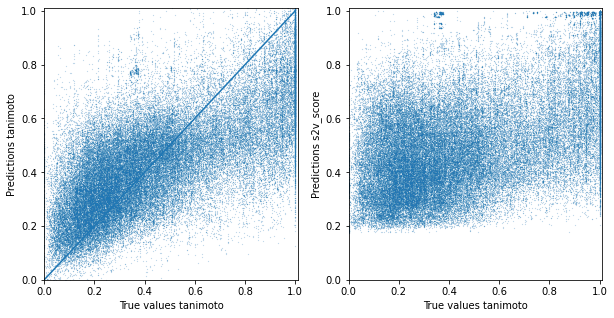

In [25]:
best_model_3_scores_predict = best_model_3_scores[0].predict(X_tanimoto_3_scores_top40_test)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True)
# plt.figure(figsize=(5,5))
axs[0].scatter(y_tanimoto_3_scores_top40_test, best_model_3_scores_predict.flatten(), s = 0.01)
lims = [0,1]
axs[0].set_xlim(0,1.01)
axs[0].set_ylim(0,1.01)
axs[0].plot(lims, lims)
axs[0].set_xlabel('True values tanimoto')
axs[0].set_ylabel('Predictions tanimoto')

axs[1].scatter(y_tanimoto_3_scores_top40_test, X_tanimoto_3_scores_top40_test.s2v_score, s = 0.01)
axs[1].set_xlabel('True values tanimoto')
axs[1].set_ylabel('Predictions s2v_score')
axs[1].set_ylim(0,1.01)
plt.show()

## Querying test set on model

In [29]:
outfile = os.path.join(path_data, 'nn_tested_found_matches_s2v_3_scores_top40.pickle')
#query and library of the test data can be found (as a tuple of (query, library)) in testing_query_library_s2v_2dec.pickle
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        nn_tested_found_matches_s2v_3_scores_top40 = pickle.load(inf)
else:
    nn_tested_found_matches_s2v_3_scores_top40 = []
    for ID in range(len(nn_prep_testing_found_matches_s2v_3_scores)):
        current_match = nn_prep_testing_found_matches_s2v_3_scores[ID].copy()
        predict_on = current_match.drop(['label', 'similarity'], axis = 1)
        predictions = best_model_3_scores[0].predict(predict_on)
        current_match['sim_predictions'] = predictions
        nn_tested_found_matches_s2v_3_scores_top40.append(current_match)
    with open(outfile, 'wb') as outf:
        pickle.dump(nn_tested_found_matches_s2v_3_scores_top40, outf)

C:\Users\joris\Documents\eScience_data\data\nn_tested_found_matches_s2v_3_scores_top40.pickle


In [34]:
nn_tested_found_matches_s2v_3_scores_top40[1].iloc[:10]

cosine_score  cosine_matches  mod_cosine_score  mod_cosine_matches  \
80809      0.014914        0.251948          0.015814            0.440418   
89154      0.080951        0.440418          0.081348            0.516018   
80812      0.024214        0.398299          0.024214            0.398299   
10227      0.029906        0.135100          0.039479            0.353010   
9571       0.050143        0.070000          0.050605            0.135100   
11075      0.050494        0.135100          0.050494            0.135100   
71306      0.050320        0.195643          0.050408            0.304312   
15237      0.050143        0.070000          0.050284            0.135100   
11294      0.050885        0.135100          0.471806            0.251948   
15256      0.051331        0.135100          0.273617            0.195643   

       s2v_score  s2v_score_1dec  s2v_score_3dec  label  similarity  \
80809   0.330213        0.160191        0.380310      0    0.695895   
89154   0.326337        0.178550        0.258132      0    0.406162   
80812   0.322860        0.143763        0.296352      0    0.695895   
10227   0.318018        0.188138        0.441650      0    0.276418   
9571    0.314467        0.130648        0.223457      0    0.242962   
11075   0.314340        0.140661        0.320326      0    0.353746   
71306   0.309901        0.161787        0.192062      0    0.415517   
15237   0.307078        0.141092        0.176289      0    0.242962   
11294   0.306522        0.080409        0.163207      0    0.230255   
15256   0.306158        0.159609        0.172032      0    0.230255   

       parent_mass      mass_sim  sim_predictions  
80809     0.081851  1.302529e-64         0.461956  
89154     0.026537  9.064443e-09         0.265058  
80812     0.083041  3.690919e-66         0.384550  
10227     0.026242  3.746920e-09         0.299213  
9571      0.022217  2.185082e-14         0.202975  
11075     0.027659  2.603431e-07         0.259078  
71306     0.027139  5.482988e-08         0.241199  
15237     0.022217  2.185569e-14         0.194046  
11294     0.030650  2.020757e-03         0.255363  
15256     0.030650  2.021208e-03         0.241996

## Making well known performance plot

In [43]:
#testing if top hit is above 0.6 similarity
#look at top20
test_tan_nn_top20 = []
test_sim_mcos = []
test_sim_s2v = []
ideal_case_top20 = []
test_3scores_nn_top40 = []

pred_thresh = 0.6
mass_sim_thresh = 0.000705
restr_nn = False # do mass+spec2vec restricitons on nn models
highest_pred = False # take highest prediction instead of first prediction over threshold
threshold = 0.5
topn = 20 #only look at top 20
sim_threshold = 0.6
mc_matches_thresh = 0.35 # mod cosine matches threshold corresponds to min match 6

for ID in range(len(nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v)):
    # mass + mod cosine
    current_match = nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['mod_cosine_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['mod_cosine_score'] > threshold)
                                  & (current_match['mod_cosine_matches'] > mc_matches_thresh)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['mod_cosine_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_mcos.append(best_bet)

    # Scenario 1: mass + Spec2Vec + threshold
    current_match = nn_tested_tanimoto_top20_new_and_unique2_found_matches_s2v[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    #inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
    #select top20
    #current_match = found_matches_s2v[ID].sort_values(by=['s2v_score'], ascending=False).iloc[:topn]

    df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                  & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        sim = df_select.iloc[0]['similarity'] #look at similarity of top hit
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_sim_s2v.append(best_bet)
    
    # Scenario 3: (Spec2Vec + threshold) after filtering for non-similar matches with nn
    if not restr_nn:
        df_select = current_match[(current_match['sim_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['sim_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['sim_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_tan_nn_top20.append(best_bet)
    
    # ideal case: how many queries have an actual match above s2v threshold and >0.6 tanimoto
    df_select = current_match[(current_match['s2v_score'] > threshold)]
    best_bet = -1
    if df_select.shape[0] > 0:
        if any(df_select['similarity'] > 0.6):
            best_bet = 1
    ideal_case_top20.append(best_bet)
    
    # Scenario 4: (Spec2Vec + threshold) with NN trained on 3 different s2v scores
    current_match = nn_tested_found_matches_s2v_3_scores_top40[ID]\
                        .sort_values(by=['s2v_score'], ascending = False).iloc[:topn]
    
    if not restr_nn:
        df_select = current_match[(current_match['sim_predictions'] >= pred_thresh)]
    else:
        df_select = current_match[(current_match['mass_sim'] >= mass_sim_thresh)
                                      & (current_match['sim_predictions'] >= pred_thresh)
                                      & (current_match['s2v_score'] > threshold)]
    
    if df_select.shape[0] > 0:
        #best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
        #inchikey_match = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        if highest_pred:
            #look at highest predicted above prediction threshold
            sim = df_select.iloc[np.argmax(df_select['sim_predictions'])]['similarity']
        else:
            #look at similarity of top hit
            sim = df_select.iloc[0]['similarity']
        best_bet = 1 * (sim >= sim_threshold)
    else:
        best_bet = -1 # meaning: not found
    test_3scores_nn_top40.append(best_bet)
    
test_tan_nn_top20_arr = np.array(test_tan_nn_top20)
test_sim_mcos_arr = np.array(test_sim_mcos)
test_sim_s2v_arr = np.array(test_sim_s2v)
ideal_case_top20_arr = np.array(ideal_case_top20)
test_3scores_nn_top40_arr = np.array(test_3scores_nn_top40)

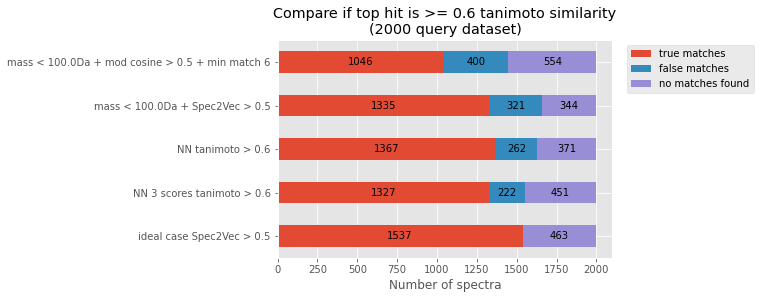

In [44]:
from math import log
plt.style.use('ggplot')
da_diff = log(mass_sim_thresh, 0.93)

if restr_nn:
    ylabels = ['mass < {:.1f}Da + mod cosine > {} + min match 6'.format(da_diff, threshold),
               'mass < {:.1f}Da + Spec2Vec > {}'.format(da_diff, threshold),
               'mass < {:.1f}Da + Spec2Vec > {}+ NN tanimoto > {}'.format(da_diff, threshold, pred_thresh),
               'ideal case Spec2Vec > {}'.format(threshold),
               'mass < {:.1f}Da + Spec2Vec > {} + NN 3 scores tanimoto > {}'.format(da_diff, threshold, pred_thresh)]
else:
    ylabels = ['mass < {:.1f}Da + mod cosine > {} + min match 6'.format(da_diff, threshold),
               'mass < {:.1f}Da + Spec2Vec > {}'.format(da_diff, threshold),
               'NN tanimoto > {}'.format(pred_thresh),
               'ideal case Spec2Vec > {}'.format(threshold),
               'NN 3 scores tanimoto > {}'.format(pred_thresh)]
xlabels = ['true matches', 'false matches', 'no matches found']
          #'mass + mod.cosine \n + as backup: Spec2Vec + mod.cosine']
data = np.array([[np.sum(test_sim_mcos_arr == 1), np.sum(test_sim_mcos_arr == 0), np.sum(test_sim_mcos_arr == -1)],
                 [np.sum(test_sim_s2v_arr == 1), np.sum(test_sim_s2v_arr == 0), np.sum(test_sim_s2v_arr == -1)],
                 [np.sum(test_tan_nn_top20_arr == 1), np.sum(test_tan_nn_top20_arr == 0), np.sum(test_tan_nn_top20_arr == -1)],
                 [np.sum(ideal_case_top20_arr == 1), np.sum(ideal_case_top20_arr == 0), np.sum(ideal_case_top20_arr == -1)],
                 [np.sum(test_3scores_nn_top40_arr == 1), np.sum(test_3scores_nn_top40_arr == 0), np.sum(test_3scores_nn_top40_arr == -1)]])

dataframe = pd.DataFrame(data, columns=xlabels, index=ylabels)

#fig, ax = plt.subplots(figsize=(5, 5))
ax = dataframe.sort_values(by=['false matches'], ascending=True).plot.barh(stacked=True, edgecolor='none', figsize=(6, 4))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if width != 0:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(width), 
                horizontalalignment='center', 
                verticalalignment='center')

horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.xlabel('Number of spectra')
plt.title('Compare if top hit is >= {} tanimoto similarity\n(2000 query dataset)'.format(sim_threshold))
#plt.figure(figsize=(5,5))
plt.show()